In [6]:
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from pyDOE import lhs
import scipy.interpolate as interpolate


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def to_tensor(d):
    return torch.from_numpy(d).float().to(device, dtype=torch.float32)

### Define the PDE function

Wavefield is a function of time and space coordinates $u=u(t, \textit{\textbf{x}}), \textit{\textbf{x}}=(x,z) \in  \mathbb{D}^2 \in  \mathbb{R}^2$, which satifies:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial z^2}\right)
$$

### Boundary conditions 
$$u(t, \textit{\textbf{x}}=\textit{\textbf{x}}_\textit{0})=s(t)$$
$$u(t_1, \textit{\textbf{x}})=u_1$$
$$u(t_2, \textit{\textbf{x}})=u_2$$


<!-- $$u(t, \textit{\textbf{x}}\notin \mathbb{D}^2)=0$$ -->


In [9]:
# Define the PINN
class PINN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__() 
        self.act = nn.Tanh()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.layers[i].bias.data)   

    def forward(self, x, z, t):
        a = torch.concatenate((x, z, t), 1)
        for i in range(len(self.layers)-2):  
            z = self.layers[i](a)              
            a = self.act(z)    
        a = self.layers[-1](a)
        return a

In [10]:
# load the config from file
import yaml
with open('forward.yml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
end_time = config['geom']['nt']*config['geom']['dt']
vel=np.load(config['geom']['truePath']['vp'])
gridnz, gridnx=vel.shape
dh = config['geom']['h']/1000.
(nz, nx)=(gridnz*dh, gridnx*dh)
print(f"The size of the model is {nz} km x {nx} km")
print(f"The modeling time is {end_time} s")

The size of the model is 2.57 km x 2.57 km
The modeling time is 1.5 s


In [12]:
# load wavefield from disk
import glob
pmln = 50
wf_files = sorted(glob.glob("./wavefield/*.npy"))

wf = np.zeros((len(wf_files), gridnz, gridnx))
for i, wf_file in enumerate(wf_files):
    wf[i] = np.load(wf_file)[0, pmln:-pmln, pmln:-pmln]
print(f"The shape of the wavefield is {wf.shape}")
# load record
record = np.load(config['geom']['obsPath'], allow_pickle=True)
plt.imshow(record[0], cmap='seismic', aspect='auto')
plt.show()

The shape of the wavefield is (1500, 257, 257)


In [7]:
# Downsample the data
time_samples = 10
start_time_in_sec = 0.4#s
end_time_in_sec = .8#s
samples_per_time = 2000
downsample = 4
dh = config['geom']['h']
dt = config['geom']['dt']

start_time = int(start_time_in_sec//config['geom']['dt'])
end_time = int(end_time_in_sec//config['geom']['dt'])
print(f"Start time: {start_time_in_sec} s")
print(f"End time: {end_time_in_sec} s")

Start time: 0.4 s
End time: 0.8 s


### Load the initial conditon at 0.4s and 0.5s

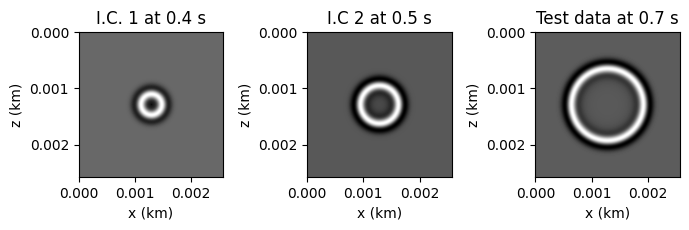

In [8]:
# initial condition 1
t1 = start_time
u0 = wf[t1]
# initial condition 2
t2 = start_time+100
u1 = wf[t2]
t3 = end_time-100
u_test = wf[t3]

fig, ax = plt.subplots(1,3, figsize=(7,3))
extent = [0, nx/1000, nz/1000, 0]
kwargs = {'extent': extent, 'cmap': 'gray', 'aspect': 'auto'}
ax[0].imshow(u0, **kwargs)
ax[1].imshow(u1, **kwargs)
ax[2].imshow(u_test, **kwargs)

ax[0].set_title(f"I.C. 1 at {t1*config['geom']['dt']} s")
ax[1].set_title(f"I.C 2 at {t2*config['geom']['dt']} s")
ax[2].set_title(f"Test data at {t3*config['geom']['dt']:.1f} s")

for ax in ax.ravel():
    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


### Downsacle the initial conditon

In [9]:
shape_before = u0.shape
u0 = u0[::downsample, ::downsample]
u1 = u1[::downsample, ::downsample]
u_test = u_test[::downsample, ::downsample]

shape_after = u0.shape
print(f"Shape before downsampling: {shape_before}")
print(f"Shape after downsampling: {shape_after}")
# Generate grid
gridnz, gridnx = u0.shape
dh = config['geom']['h']

xx, zz = np.meshgrid(np.linspace(0,nx,gridnx),np.linspace(0,nz,gridnz))
xx0 = to_tensor(xx.reshape((-1,1)))
zz0 = to_tensor(zz.reshape((-1,1)))
#for enforcing the disp I.C 1
tt0 = 0.0*np.ones(gridnx*gridnz)
tt0 = to_tensor(tt0.reshape((-1,1)))
#for enforcing the sec I.C 2
tt1 = (t2-t1)*dt*np.ones(gridnx*gridnz)
tt1 = to_tensor(tt1.reshape((-1,1)))
# Test data
tt_test = (t3-t1)*dt*np.ones(gridnx*gridnz)
tt_test = to_tensor(tt_test.reshape((-1,1)))
print(f"The pinn will be trained at {tt1.max():.1f}s, {tt0.max():.1f}s and tested at {tt_test.max():.1f}s")

Shape before downsampling: (257, 257)
Shape after downsampling: (65, 65)
The pinn will be trained at 0.1s, 0.0s and tested at 0.3s


In [10]:
print(xx0.max(), zz0.max(), tt0.max())
print(xx0.max(), zz0.max(), tt1.max())
print(xx0.max(), zz0.max(), tt_test.max())

tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0., device='cuda:0')
tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0.1000, device='cuda:0')
tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0.3000, device='cuda:0')


In [11]:
print(u0.max(), u0.min(), u1.max(), u1.min(), u_test.max(), u_test.min())

4.343089580535889 -3.0219902992248535 3.2284958362579346 -1.6979907751083374 2.349215030670166 -1.3343186378479004


In [12]:
# After downsampling
# fig, ax = plt.subplots(1,3, figsize=(7,3))
# extent = [0, nx/1000, nz/1000, 0]
# ax[0].imshow(u0, extent=extent, cmap='gray')
# ax[1].imshow(u1, extent=extent, cmap='gray')
# ax[2].imshow(u_test, extent=extent, cmap='gray')

# ax[0].set_title(f"Initial Condition 1 at {t1*config['geom']['dt']} s")
# ax[1].set_title(f"Initial Condition 2 at {t2*config['geom']['dt']} s")
# ax[2].set_title(f"Test data at {t3*config['geom']['dt']} s")

# for ax in ax.ravel():
#     ax.set_xlabel('x (km)')
#     ax.set_ylabel('z (km)')
#     ax.set_aspect('equal')

# plt.tight_layout()
# plt.show()

### Train the network

In [13]:
epochs = 200000
lr=1e-4
pinn = PINN([3, 50, 50, 50, 50, 1])
optimizer = torch.optim.Adam(pinn.parameters(),lr=lr,amsgrad=False)
pinn.to('cuda')

u0 = torch.from_numpy(u0.flatten()).float().to('cuda')
u1 = torch.from_numpy(u1.flatten()).float().to('cuda')
u_test = torch.from_numpy(u_test).float().to('cuda')

In [14]:
end_time_in_sec

0.8

In [15]:
# points for evaluating the pde
train_end_time = 0.8#s
n_samples=int(2e4)
points = lhs(3, n_samples)
x_pde = torch.concatenate((to_tensor(points[:,0]*nx).unsqueeze(1), xx0.clone(), xx0.clone()))
z_pde = torch.concatenate((to_tensor(points[:,1]*nz).unsqueeze(1), zz0.clone(), zz0.clone()))
t_pde = torch.concatenate((to_tensor(points[:,1]*train_end_time).unsqueeze(1), tt0.clone(), tt1.clone()))
x_pde.requires_grad = True
z_pde.requires_grad = True
t_pde.requires_grad = True
pde_zero = torch.zeros(x_pde.shape[0], 1).to('cuda')
print(x_pde.shape, z_pde.shape)
print(x_pde.max(), z_pde.max(), t_pde.max())
print(x_pde.min(), z_pde.min(), t_pde.min())

torch.Size([28450, 1]) torch.Size([28450, 1])
tensor(2.5700, device='cuda:0', grad_fn=<MaxBackward1>) tensor(2.5700, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.8000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0 | Loss 1.351429 | Loss_ini 1.351409 | Loss_pde 0.194353


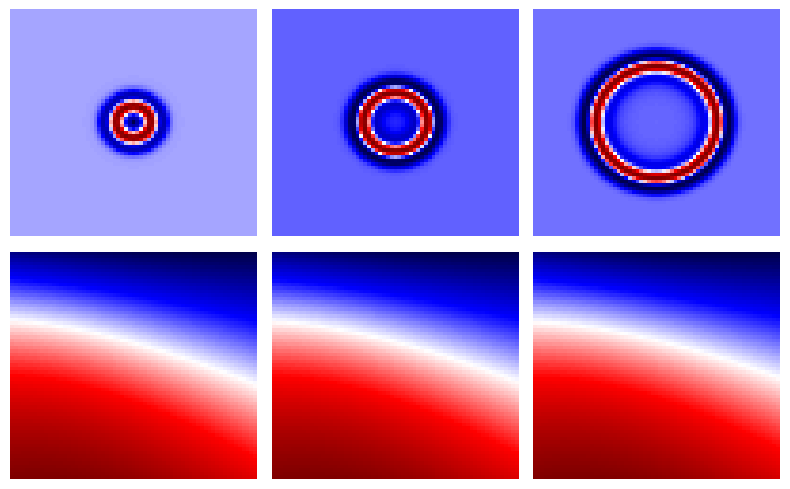

  0%|          | 993/200000 [00:10<35:23, 93.70it/s] 

Epoch 1000 | Loss 0.662181 | Loss_ini 0.662179 | Loss_pde 0.019061


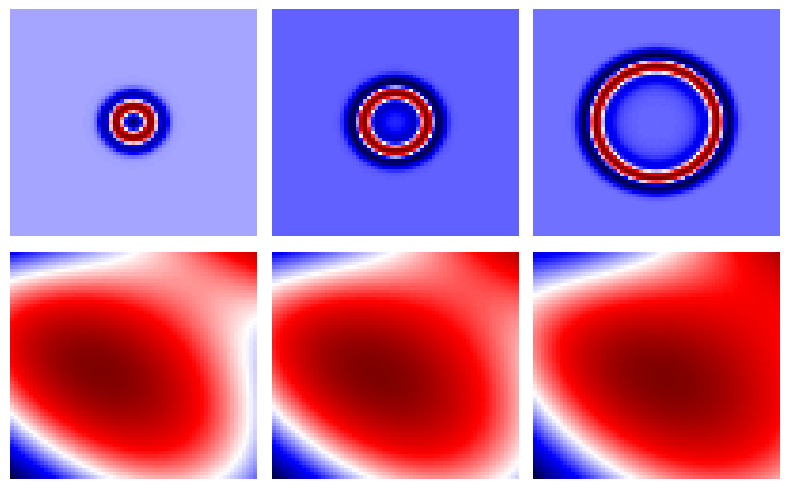

  1%|          | 1994/200000 [00:21<35:17, 93.51it/s]

Epoch 2000 | Loss 0.662131 | Loss_ini 0.662129 | Loss_pde 0.016147


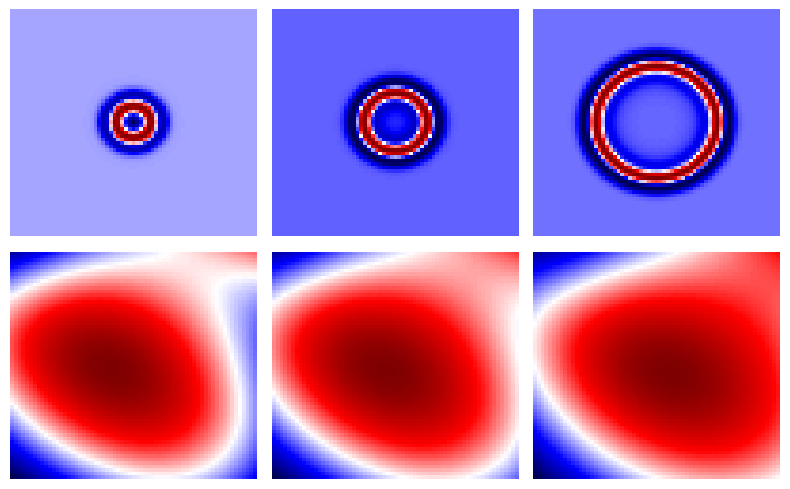

  1%|▏         | 2996/200000 [00:32<35:26, 92.65it/s]

Epoch 3000 | Loss 0.662077 | Loss_ini 0.662076 | Loss_pde 0.014236


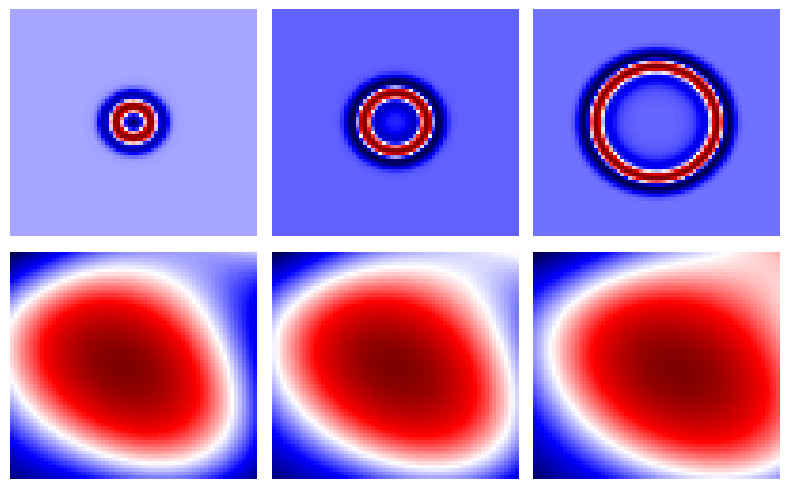

  2%|▏         | 3998/200000 [00:43<34:59, 93.35it/s]

Epoch 4000 | Loss 0.661970 | Loss_ini 0.661968 | Loss_pde 0.019021


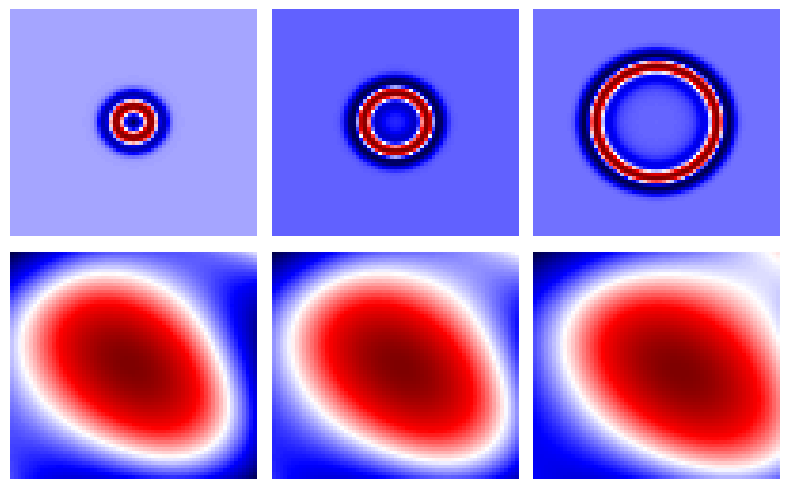

  2%|▏         | 4999/200000 [00:54<34:47, 93.40it/s]  

Epoch 5000 | Loss 0.661400 | Loss_ini 0.661386 | Loss_pde 0.136920


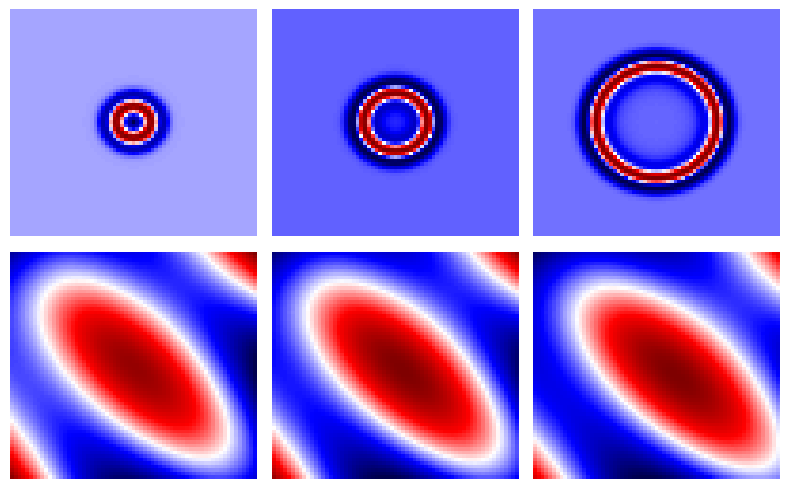

  3%|▎         | 5991/200000 [01:05<34:39, 93.30it/s]

Epoch 6000 | Loss 0.659052 | Loss_ini 0.658808 | Loss_pde 2.441333


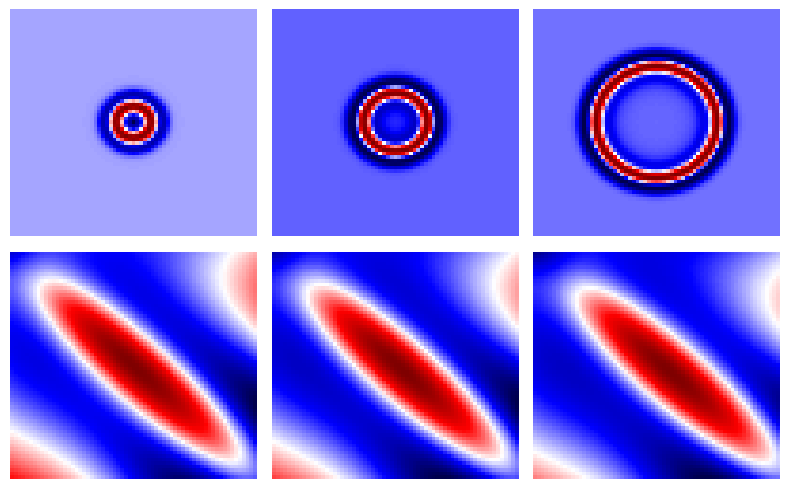

  3%|▎         | 6992/200000 [01:16<34:37, 92.90it/s]

Epoch 7000 | Loss 0.656005 | Loss_ini 0.655181 | Loss_pde 8.241644


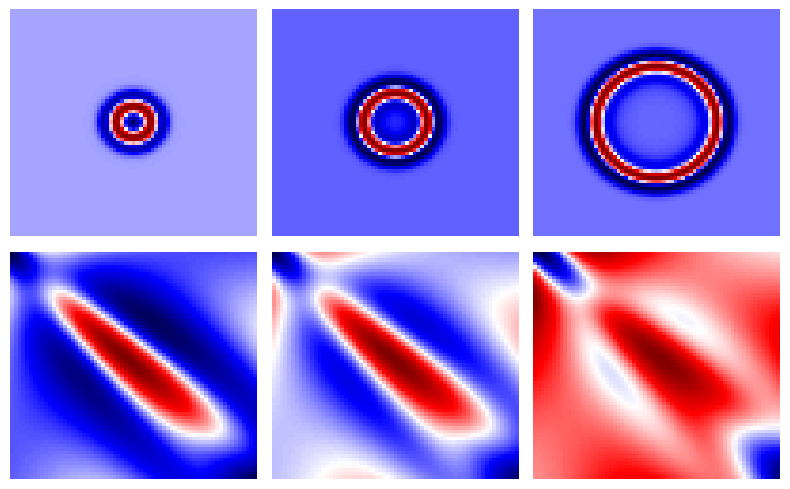

  4%|▍         | 7995/200000 [01:27<34:19, 93.24it/s]

Epoch 8000 | Loss 0.644559 | Loss_ini 0.643647 | Loss_pde 9.119153


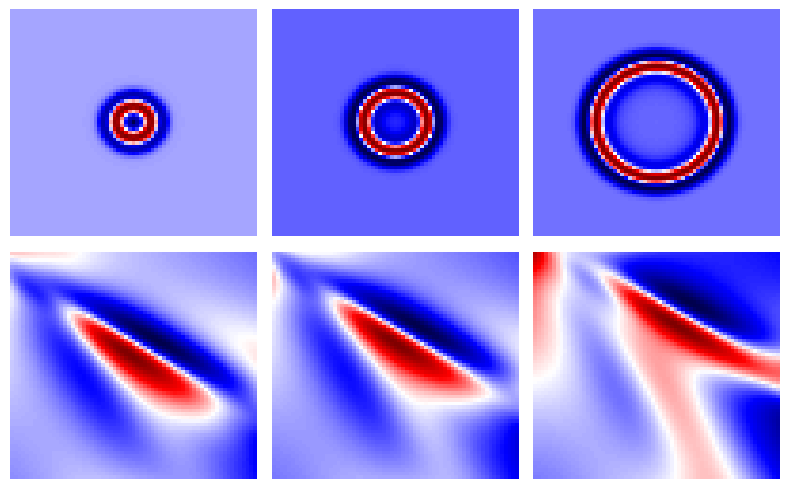

  4%|▍         | 8991/200000 [01:38<34:10, 93.17it/s]

Epoch 9000 | Loss 0.527655 | Loss_ini 0.524077 | Loss_pde 35.789326


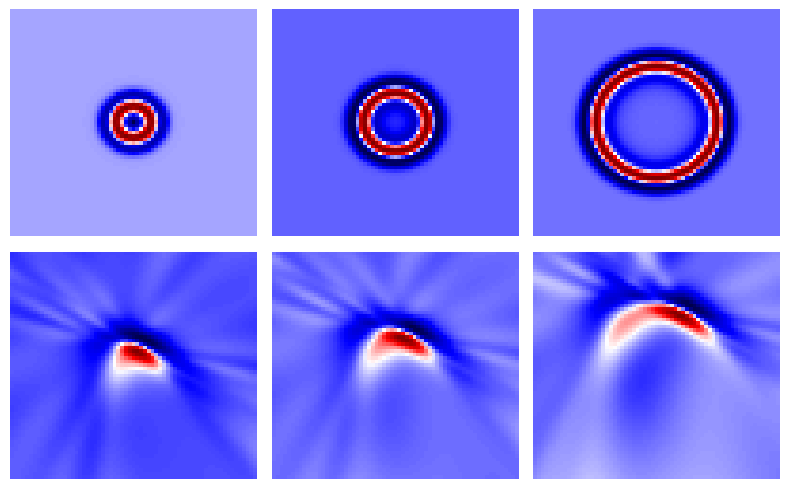

  5%|▍         | 9996/200000 [01:49<33:58, 93.20it/s]

Epoch 10000 | Loss 0.323679 | Loss_ini 0.303591 | Loss_pde 200.877579


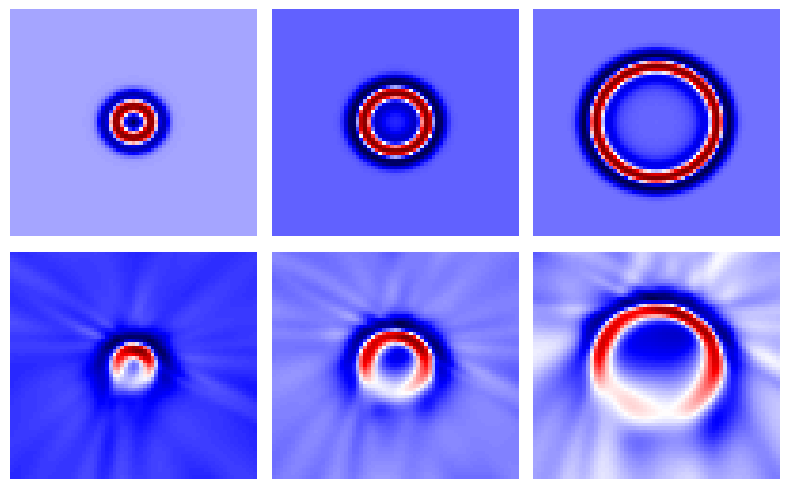

  5%|▌         | 10998/200000 [02:00<33:47, 93.24it/s]  

Epoch 11000 | Loss 0.101708 | Loss_ini 0.076552 | Loss_pde 251.560822


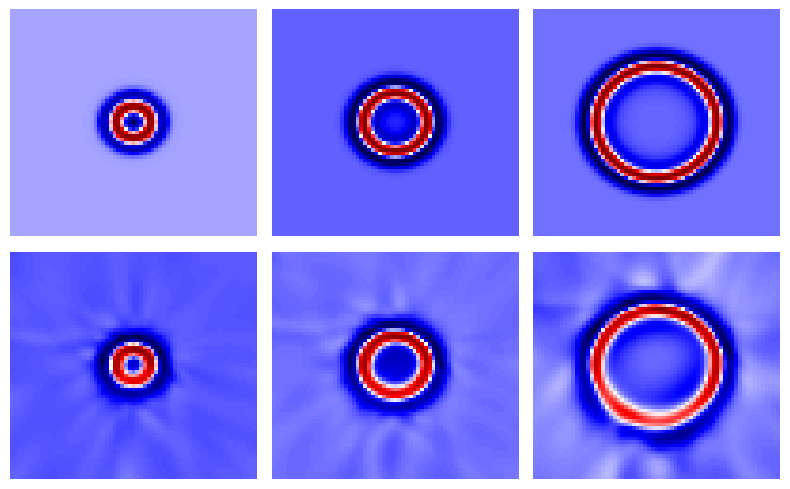

  6%|▌         | 11998/200000 [02:11<33:37, 93.19it/s]

Epoch 12000 | Loss 0.030751 | Loss_ini 0.017936 | Loss_pde 128.151825


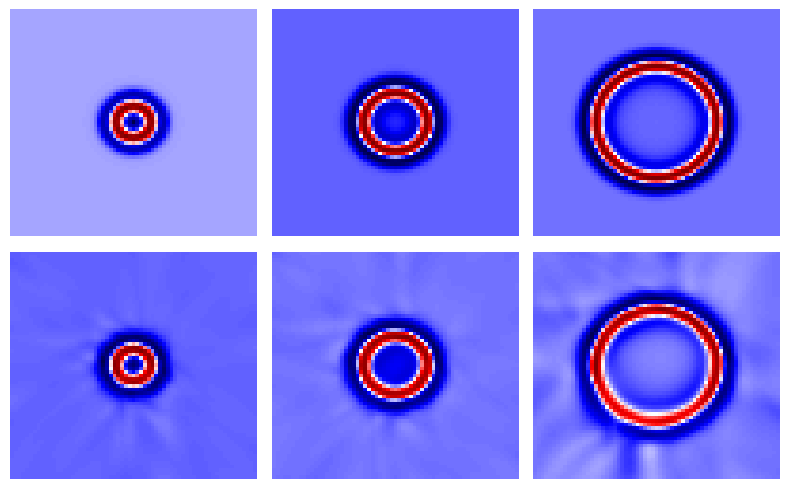

  6%|▋         | 13000/200000 [02:22<33:36, 92.75it/s]

Epoch 13000 | Loss 0.012277 | Loss_ini 0.005809 | Loss_pde 64.679344


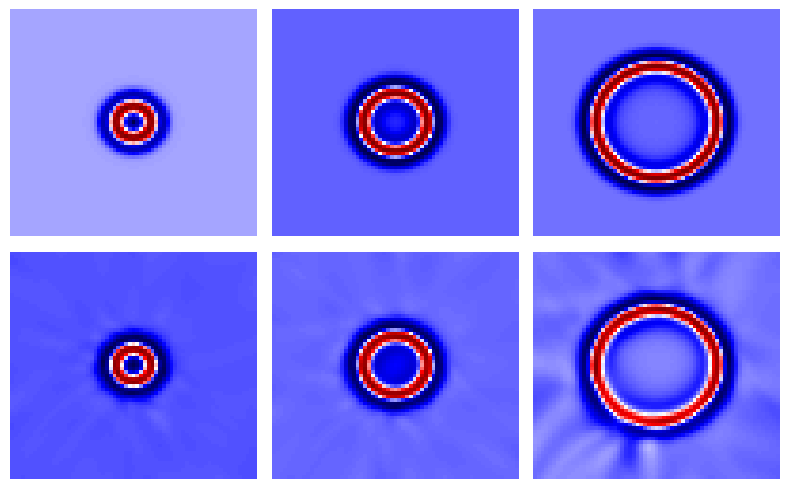

  7%|▋         | 14000/200000 [02:33<33:21, 92.95it/s]

Epoch 14000 | Loss 0.007153 | Loss_ini 0.003270 | Loss_pde 38.827309


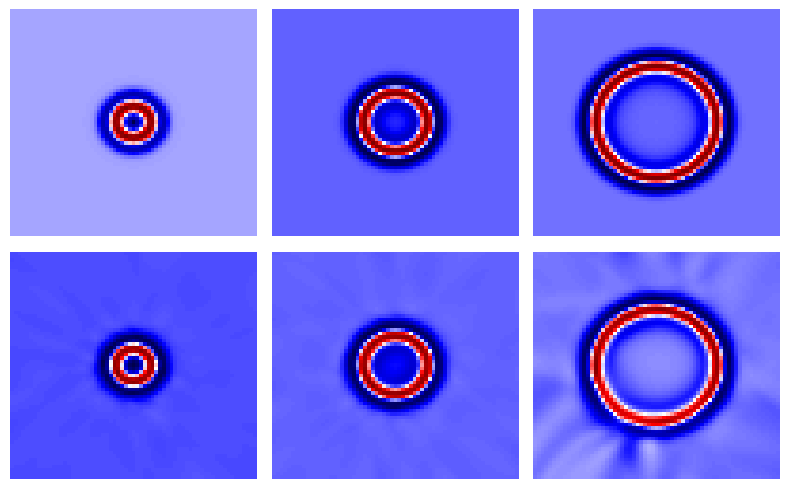

  7%|▋         | 14991/200000 [02:44<33:04, 93.22it/s]

Epoch 15000 | Loss 0.005048 | Loss_ini 0.002292 | Loss_pde 27.557077


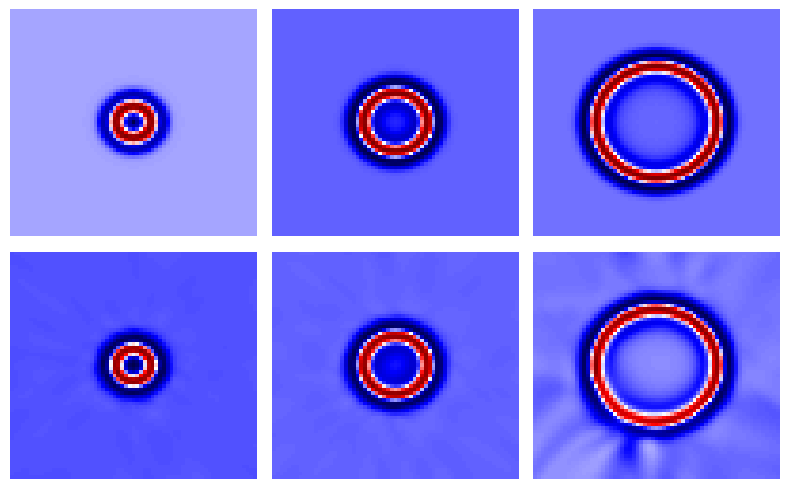

  8%|▊         | 15992/200000 [02:55<32:54, 93.20it/s]

Epoch 16000 | Loss 0.003914 | Loss_ini 0.001774 | Loss_pde 21.394114


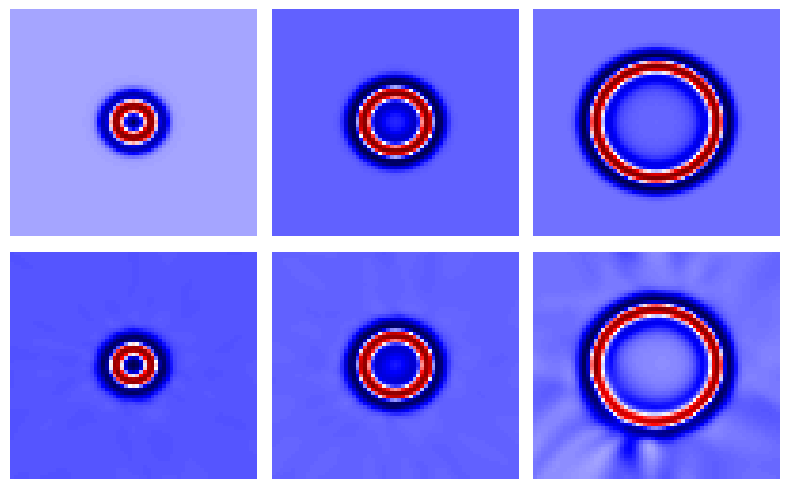

  8%|▊         | 16993/200000 [03:06<33:29, 91.08it/s]

Epoch 17000 | Loss 0.003206 | Loss_ini 0.001454 | Loss_pde 17.523872


  9%|▉         | 17996/200000 [03:17<32:32, 93.22it/s]  

Epoch 18000 | Loss 0.002725 | Loss_ini 0.001238 | Loss_pde 14.874743


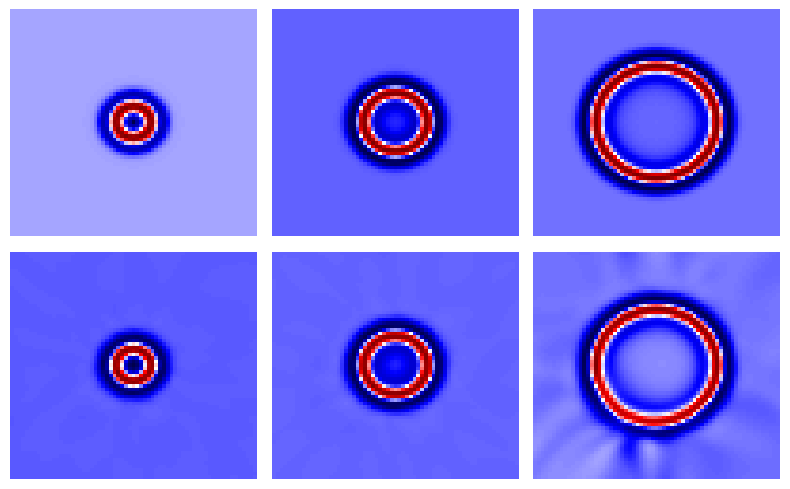

  9%|▉         | 18998/200000 [03:28<32:20, 93.26it/s]

Epoch 19000 | Loss 0.002376 | Loss_ini 0.001084 | Loss_pde 12.920193


 10%|▉         | 19999/200000 [03:39<32:13, 93.11it/s]

Epoch 20000 | Loss 0.002114 | Loss_ini 0.000973 | Loss_pde 11.411182


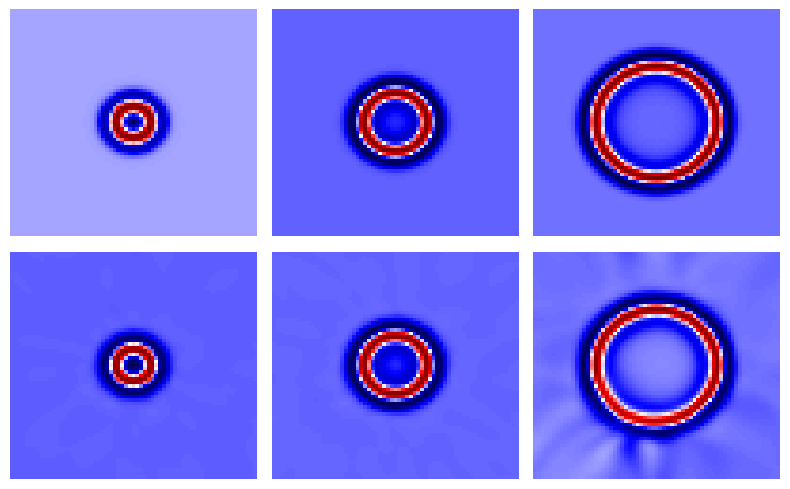

 10%|█         | 20992/200000 [03:50<31:57, 93.33it/s]

Epoch 21000 | Loss 0.001901 | Loss_ini 0.000879 | Loss_pde 10.221491


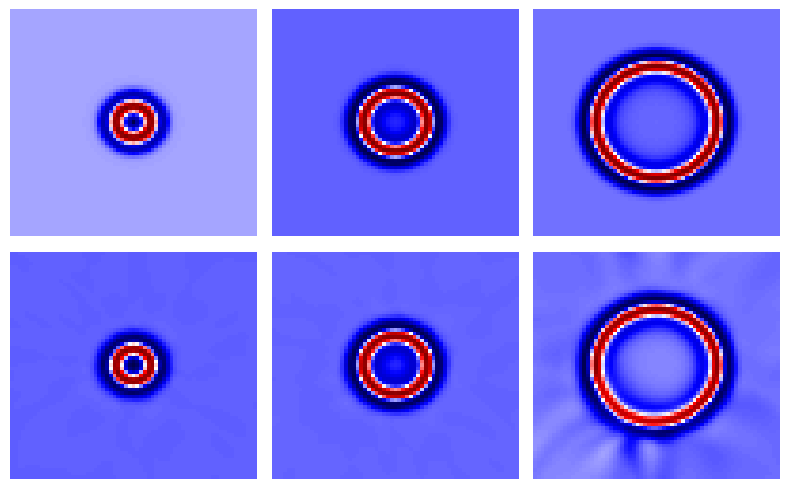

 11%|█         | 21993/200000 [04:01<31:46, 93.38it/s]

Epoch 22000 | Loss 0.001739 | Loss_ini 0.000813 | Loss_pde 9.264261


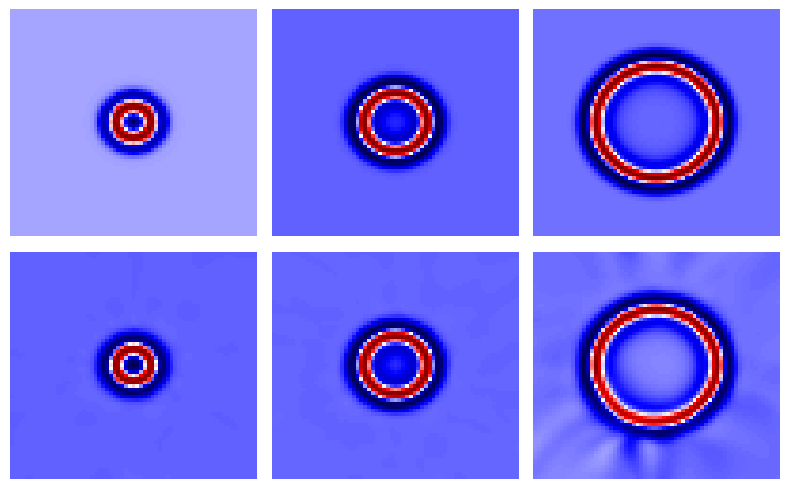

 11%|█▏        | 22995/200000 [04:12<31:38, 93.26it/s]

Epoch 23000 | Loss 0.001597 | Loss_ini 0.000751 | Loss_pde 8.463230


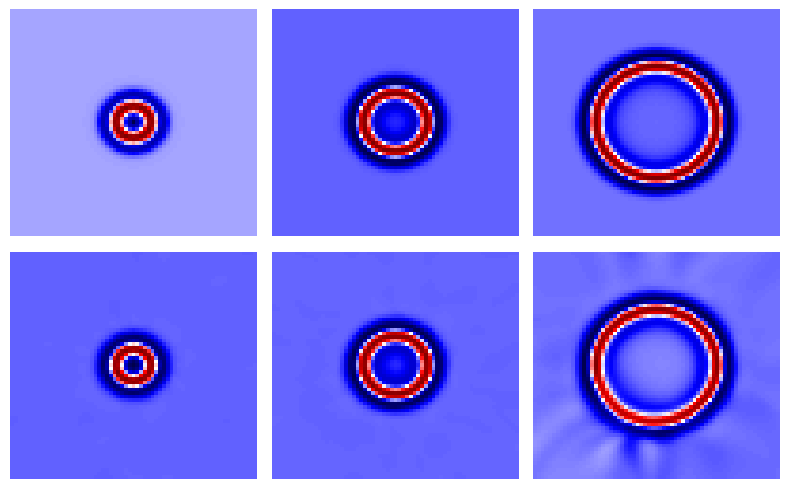

 12%|█▏        | 23996/200000 [04:23<31:31, 93.06it/s]

Epoch 24000 | Loss 0.001483 | Loss_ini 0.000703 | Loss_pde 7.798306


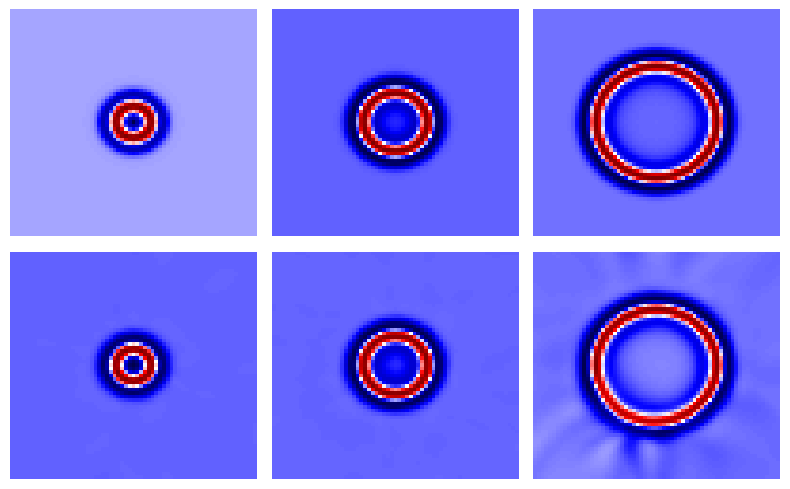

 12%|█▏        | 24995/200000 [04:34<31:18, 93.17it/s]  

Epoch 25000 | Loss 0.001387 | Loss_ini 0.000664 | Loss_pde 7.227386


 13%|█▎        | 25996/200000 [04:45<31:07, 93.16it/s]

Epoch 26000 | Loss 0.001303 | Loss_ini 0.000627 | Loss_pde 6.756189


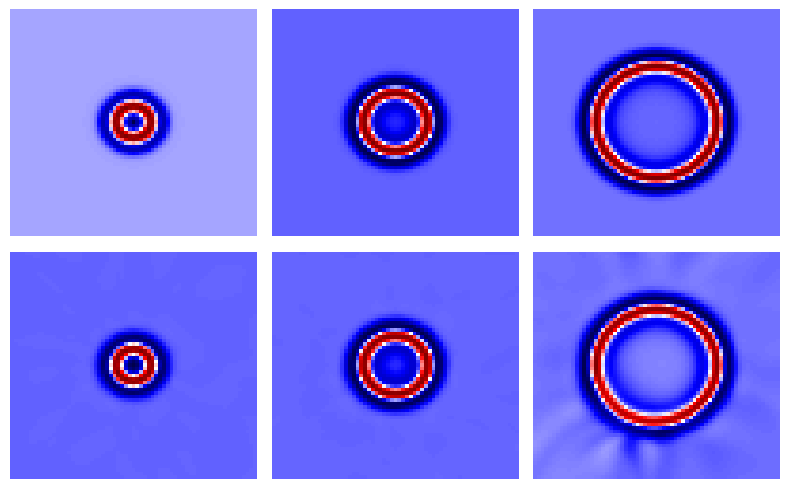

 13%|█▎        | 26999/200000 [04:56<31:01, 92.96it/s]

Epoch 27000 | Loss 0.001230 | Loss_ini 0.000596 | Loss_pde 6.338688


 14%|█▍        | 27999/200000 [05:07<30:48, 93.04it/s]

Epoch 28000 | Loss 0.001167 | Loss_ini 0.000570 | Loss_pde 5.975682


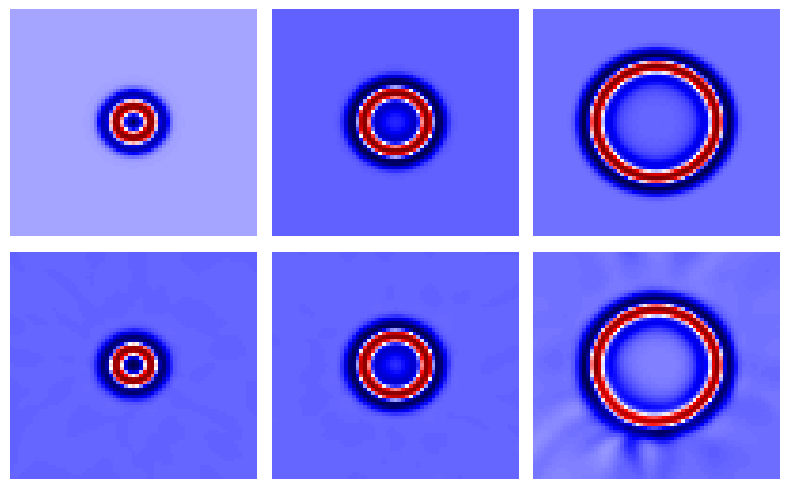

 14%|█▍        | 28998/200000 [05:18<30:36, 93.10it/s]

Epoch 29000 | Loss 0.001121 | Loss_ini 0.000556 | Loss_pde 5.659241


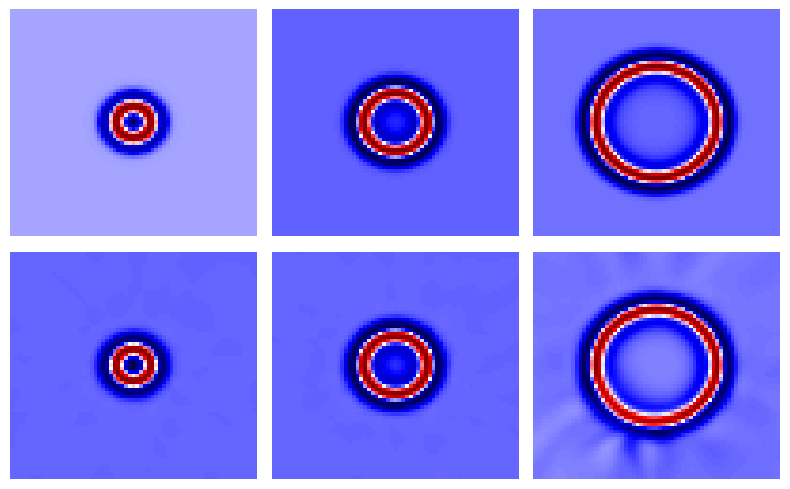

 15%|█▍        | 29999/200000 [05:29<30:27, 93.00it/s]

Epoch 30000 | Loss 0.001063 | Loss_ini 0.000525 | Loss_pde 5.382655


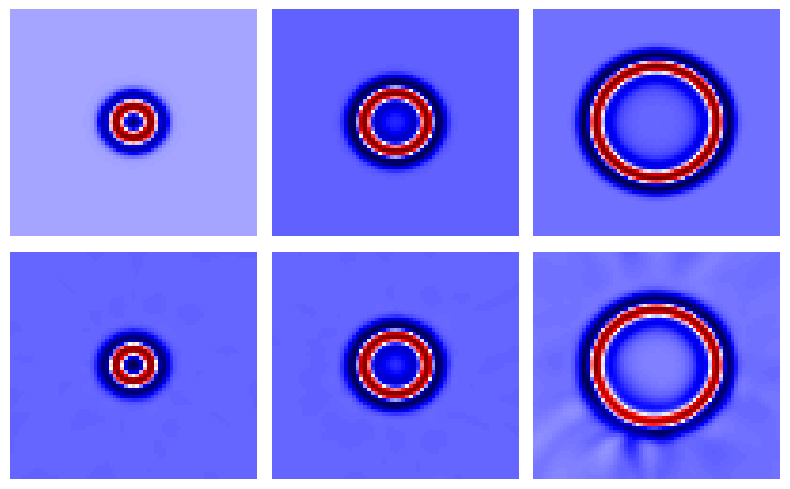

 15%|█▌        | 30991/200000 [05:40<30:16, 93.06it/s]

Epoch 31000 | Loss 0.001019 | Loss_ini 0.000506 | Loss_pde 5.134176


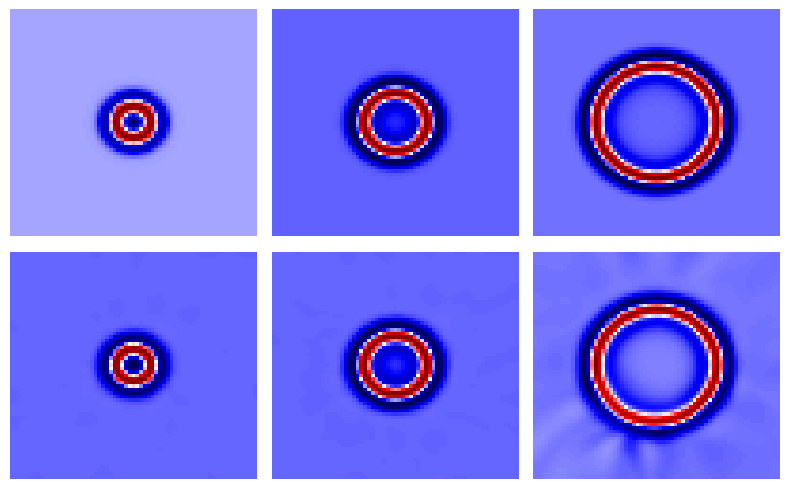

 16%|█▌        | 31992/200000 [05:51<30:05, 93.05it/s]  

Epoch 32000 | Loss 0.000989 | Loss_ini 0.000499 | Loss_pde 4.907250


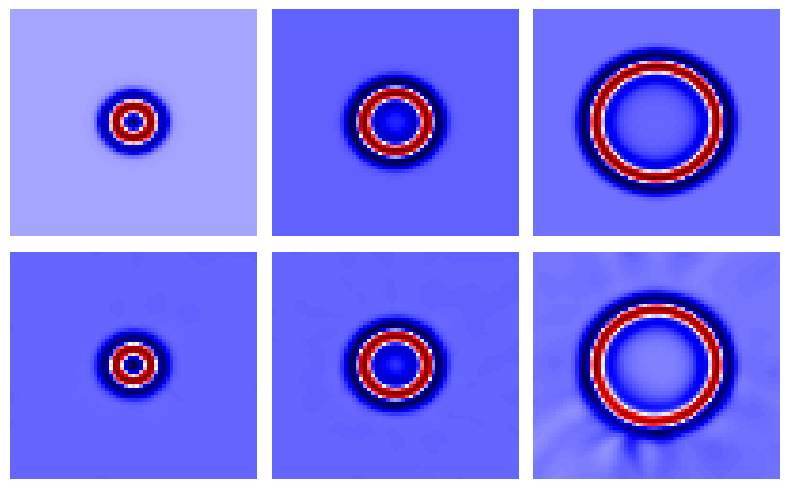

 16%|█▋        | 32994/200000 [06:02<29:55, 93.01it/s]

Epoch 33000 | Loss 0.000944 | Loss_ini 0.000473 | Loss_pde 4.707167


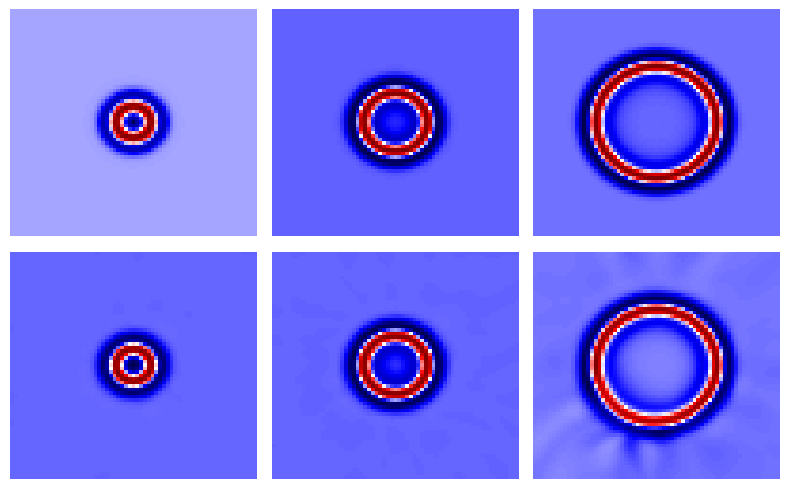

 17%|█▋        | 33995/200000 [06:13<29:43, 93.07it/s]

Epoch 34000 | Loss 0.000941 | Loss_ini 0.000486 | Loss_pde 4.551668


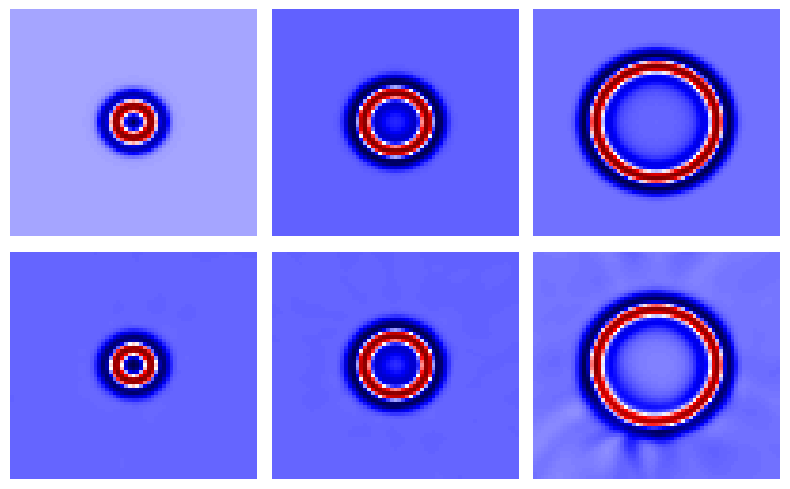

 17%|█▋        | 34997/200000 [06:24<29:33, 93.03it/s]

Epoch 35000 | Loss 0.000881 | Loss_ini 0.000446 | Loss_pde 4.352285


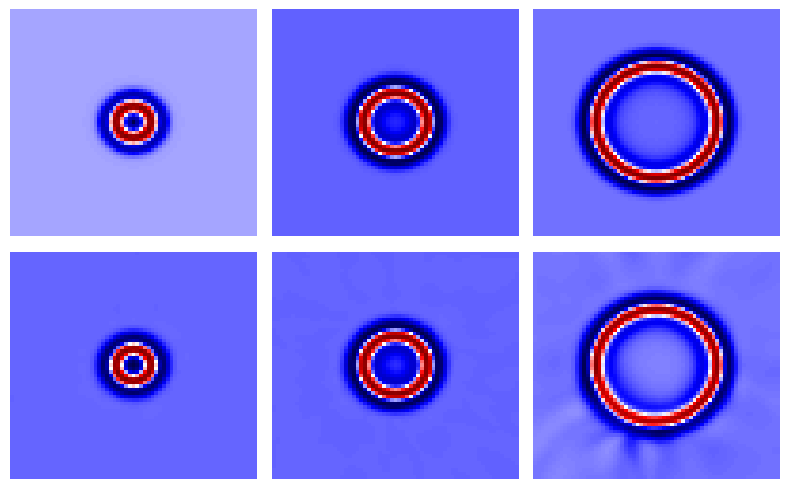

 18%|█▊        | 35997/200000 [06:35<29:23, 93.02it/s]

Epoch 36000 | Loss 0.000853 | Loss_ini 0.000434 | Loss_pde 4.195783


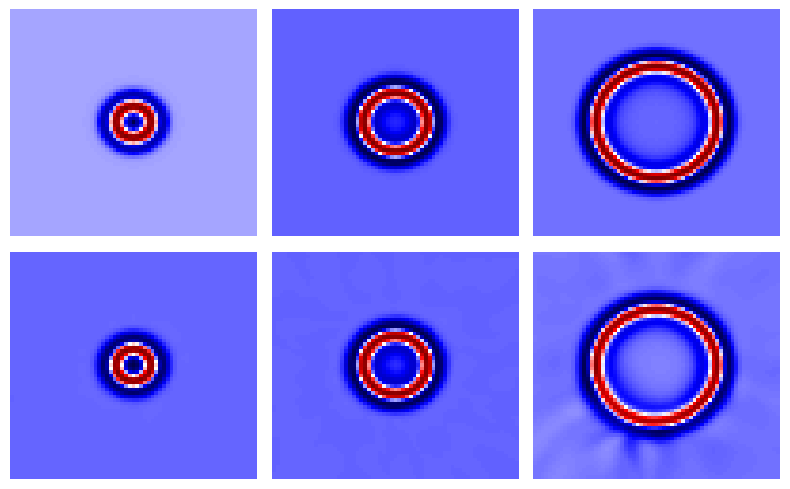

 18%|█▊        | 36997/200000 [06:46<29:11, 93.04it/s]

Epoch 37000 | Loss 0.000827 | Loss_ini 0.000422 | Loss_pde 4.050635


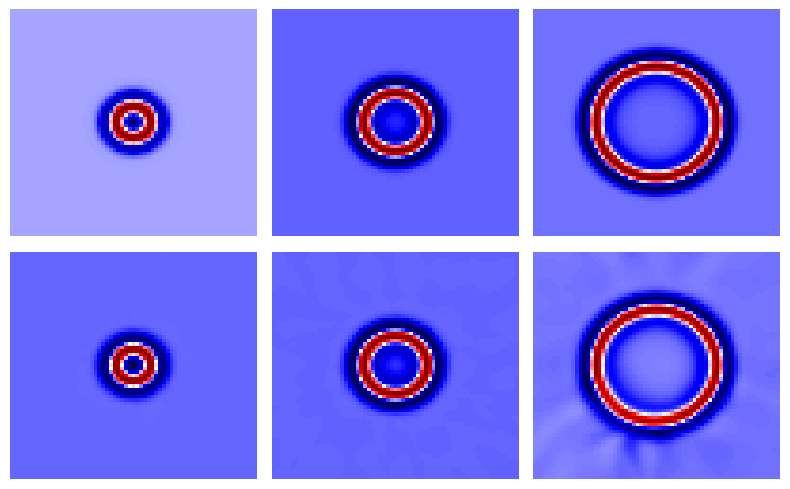

 19%|█▉        | 37997/200000 [06:57<29:02, 92.98it/s]

Epoch 38000 | Loss 0.000805 | Loss_ini 0.000413 | Loss_pde 3.916460


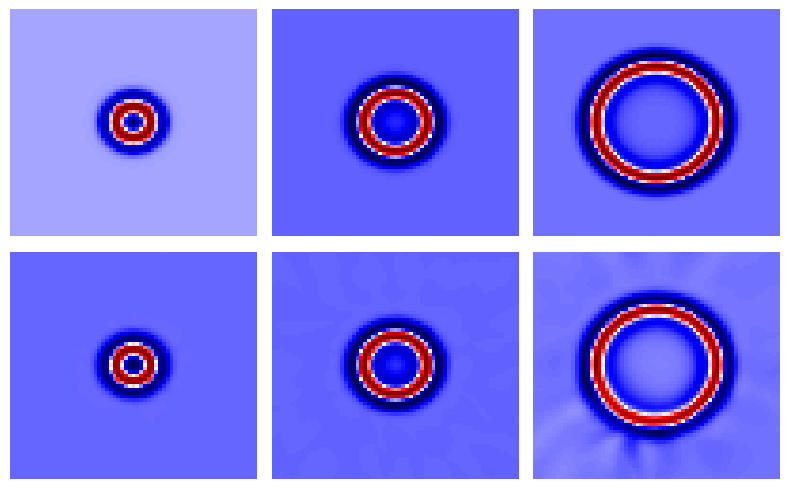

 19%|█▉        | 38997/200000 [07:08<28:48, 93.13it/s]

Epoch 39000 | Loss 0.000780 | Loss_ini 0.000401 | Loss_pde 3.796760


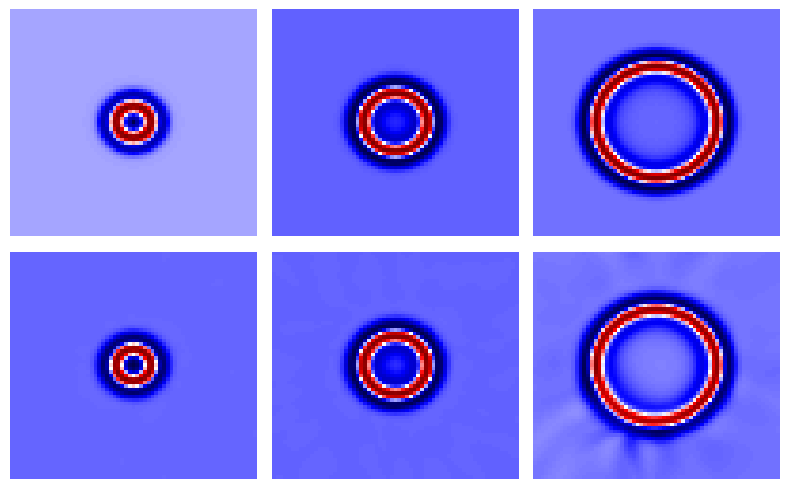

 20%|█▉        | 39997/200000 [07:19<28:39, 93.04it/s]

Epoch 40000 | Loss 0.000766 | Loss_ini 0.000397 | Loss_pde 3.689694


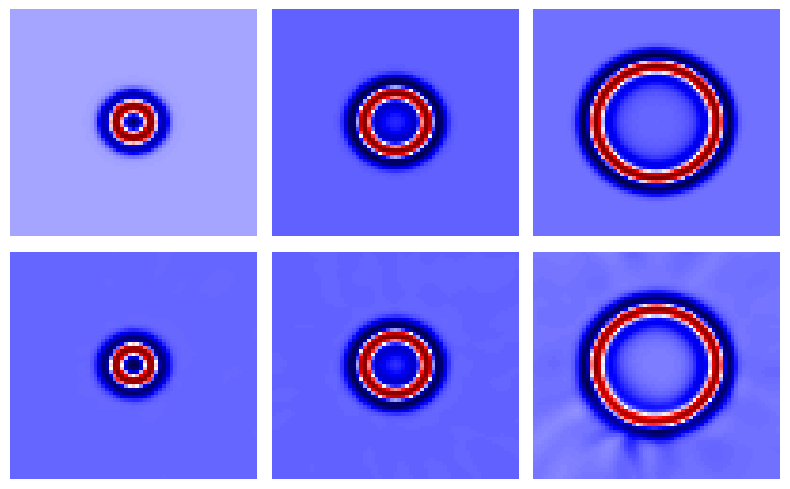

 20%|██        | 40998/200000 [07:30<28:32, 92.83it/s]

Epoch 41000 | Loss 0.000743 | Loss_ini 0.000385 | Loss_pde 3.584050


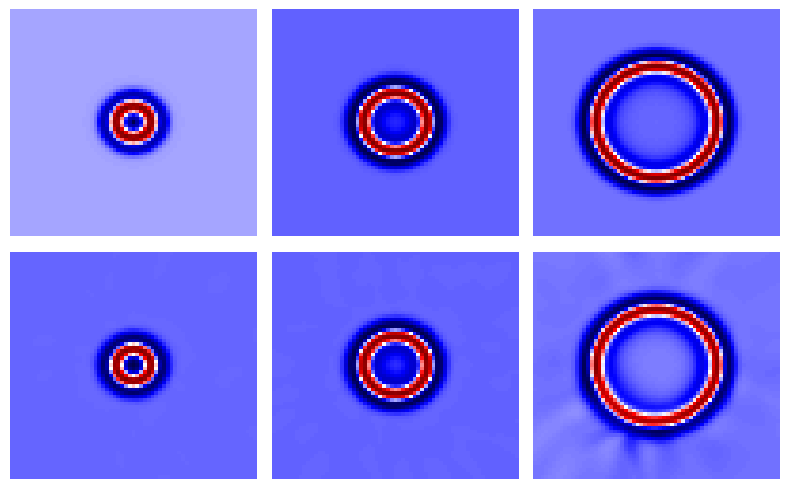

 21%|██        | 41999/200000 [07:41<28:20, 92.89it/s]

Epoch 42000 | Loss 0.000721 | Loss_ini 0.000374 | Loss_pde 3.466476


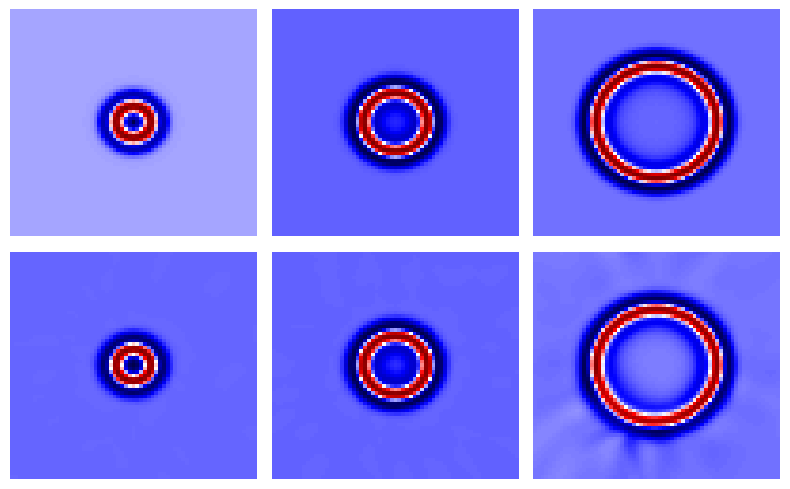

 21%|██▏       | 42999/200000 [07:52<28:09, 92.90it/s]

Epoch 43000 | Loss 0.000703 | Loss_ini 0.000366 | Loss_pde 3.371706


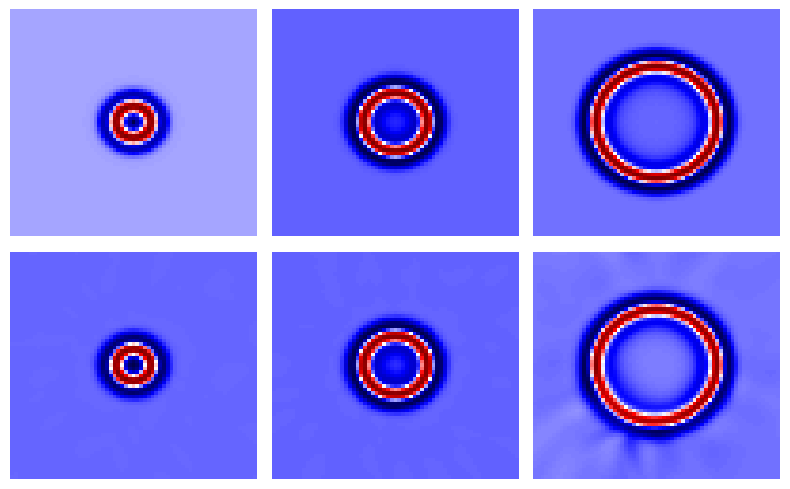

 22%|██▏       | 43999/200000 [08:03<27:59, 92.88it/s]

Epoch 44000 | Loss 0.000687 | Loss_ini 0.000359 | Loss_pde 3.278237


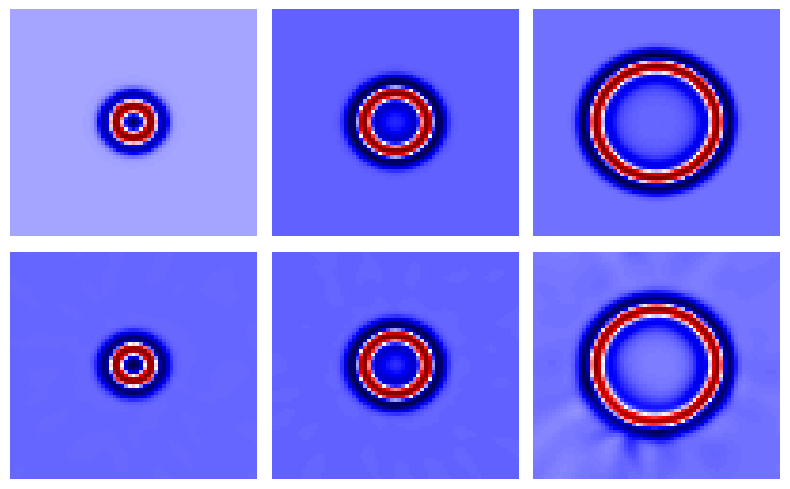

 22%|██▏       | 44999/200000 [08:14<27:49, 92.85it/s]

Epoch 45000 | Loss 0.000671 | Loss_ini 0.000352 | Loss_pde 3.193071


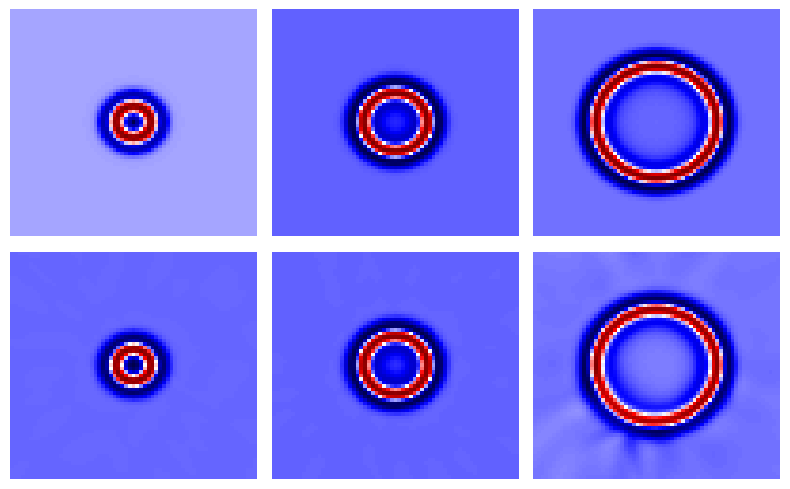

 23%|██▎       | 45999/200000 [08:25<27:38, 92.88it/s]

Epoch 46000 | Loss 0.000658 | Loss_ini 0.000347 | Loss_pde 3.108815


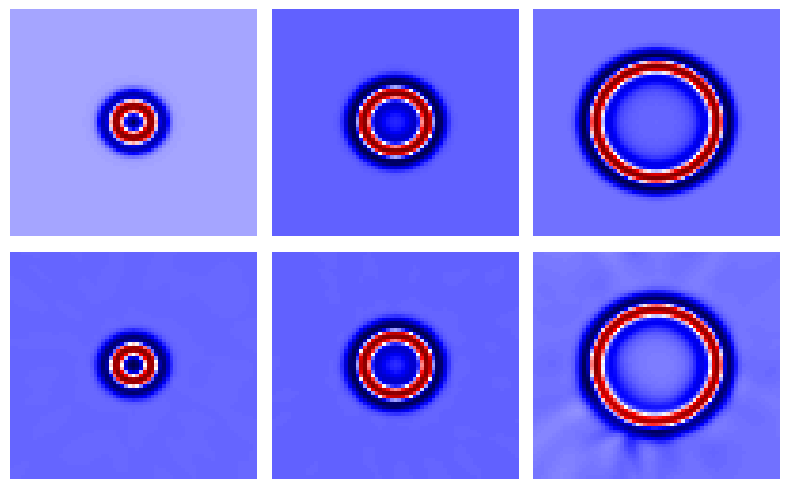

 23%|██▎       | 46999/200000 [08:36<27:28, 92.82it/s]

Epoch 47000 | Loss 0.000642 | Loss_ini 0.000339 | Loss_pde 3.032623


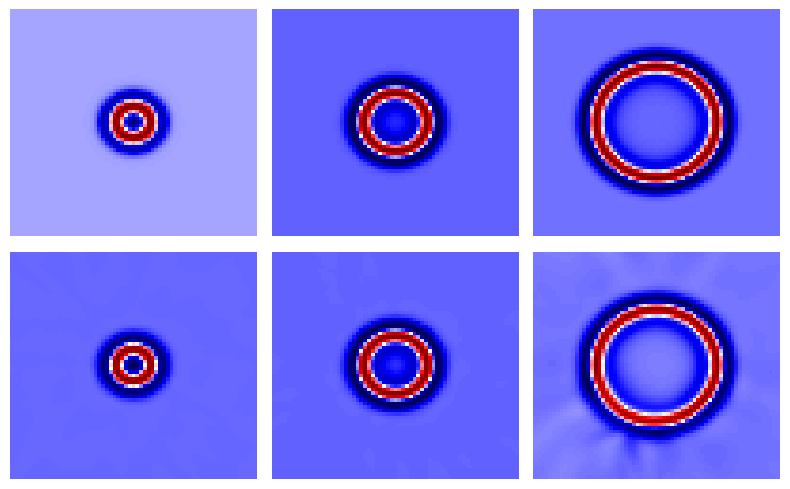

 24%|██▍       | 48000/200000 [08:47<27:17, 92.80it/s]

Epoch 48000 | Loss 0.000629 | Loss_ini 0.000333 | Loss_pde 2.960534


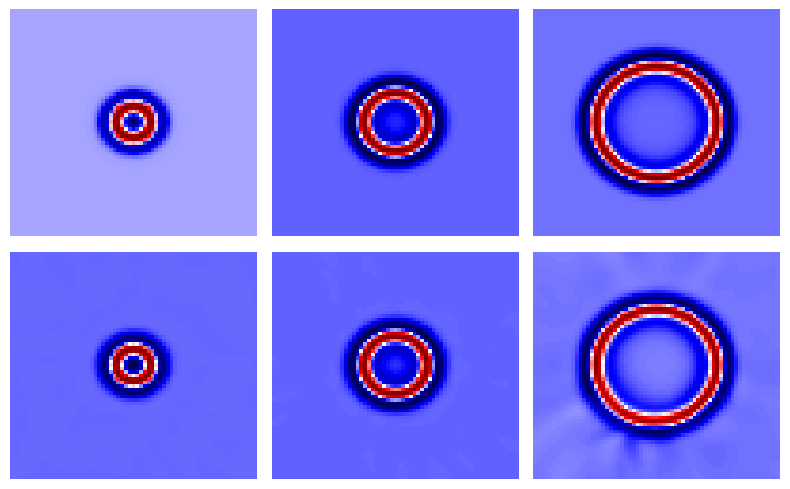

 24%|██▍       | 49000/200000 [08:58<27:05, 92.87it/s]

Epoch 49000 | Loss 0.000618 | Loss_ini 0.000329 | Loss_pde 2.888184


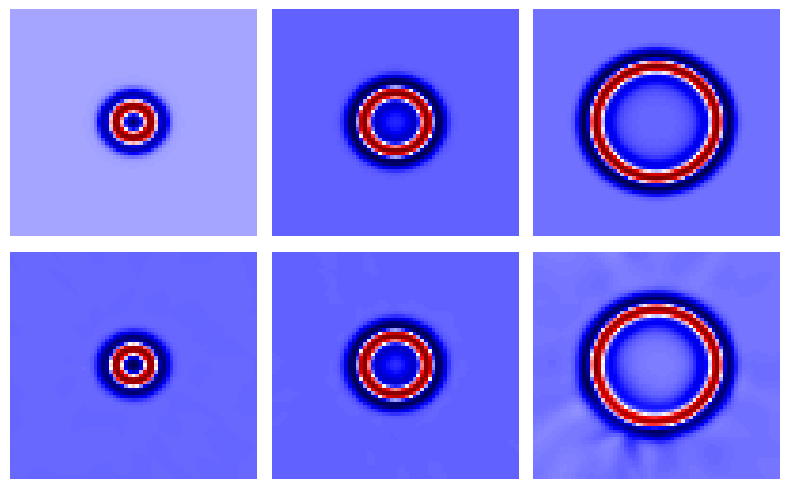

 25%|██▌       | 50000/200000 [09:09<26:56, 92.82it/s]

Epoch 50000 | Loss 0.000604 | Loss_ini 0.000322 | Loss_pde 2.824889


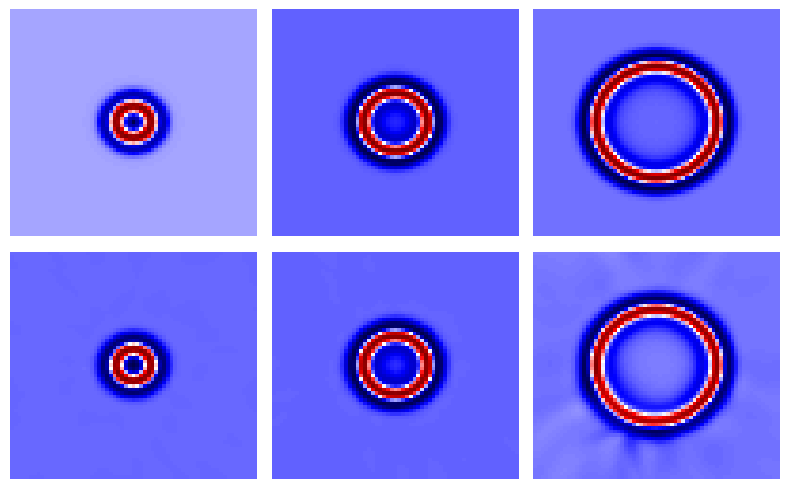

 26%|██▌       | 51000/200000 [09:20<26:44, 92.84it/s]

Epoch 51000 | Loss 0.000594 | Loss_ini 0.000318 | Loss_pde 2.758546


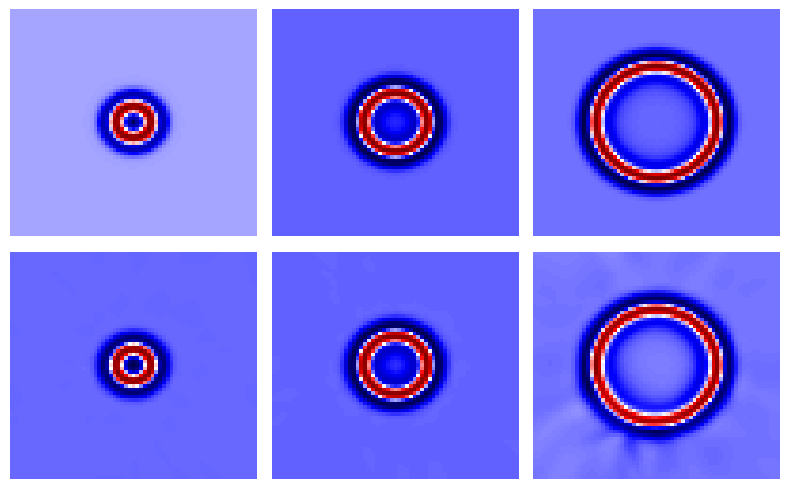

 26%|██▌       | 52000/200000 [09:31<26:31, 93.01it/s]

Epoch 52000 | Loss 0.000607 | Loss_ini 0.000336 | Loss_pde 2.708462


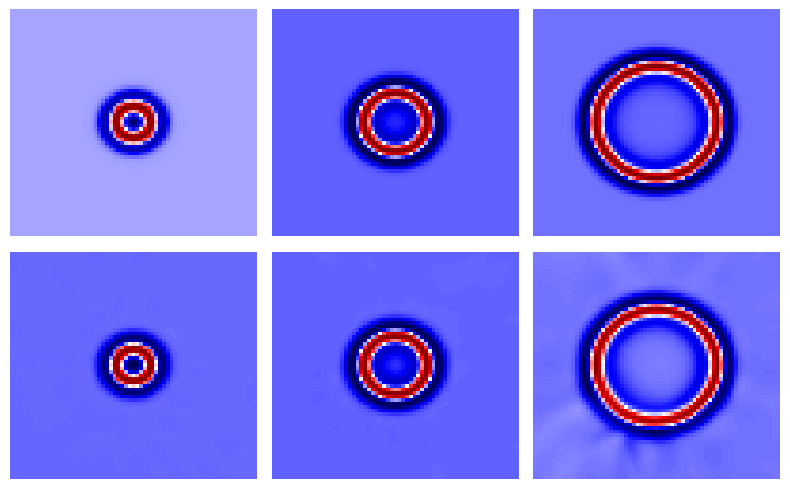

 26%|██▋       | 52991/200000 [09:41<26:23, 92.82it/s]

Epoch 53000 | Loss 0.000571 | Loss_ini 0.000307 | Loss_pde 2.642822


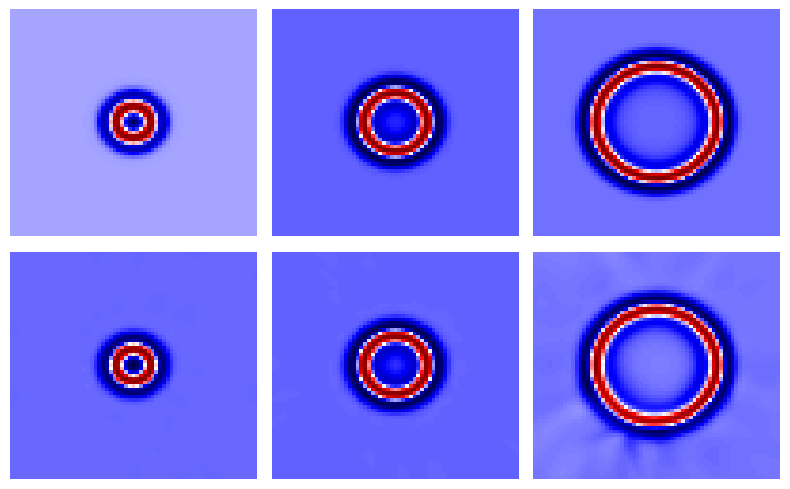

 27%|██▋       | 53992/200000 [09:52<26:12, 92.82it/s]

Epoch 54000 | Loss 0.000564 | Loss_ini 0.000305 | Loss_pde 2.585758


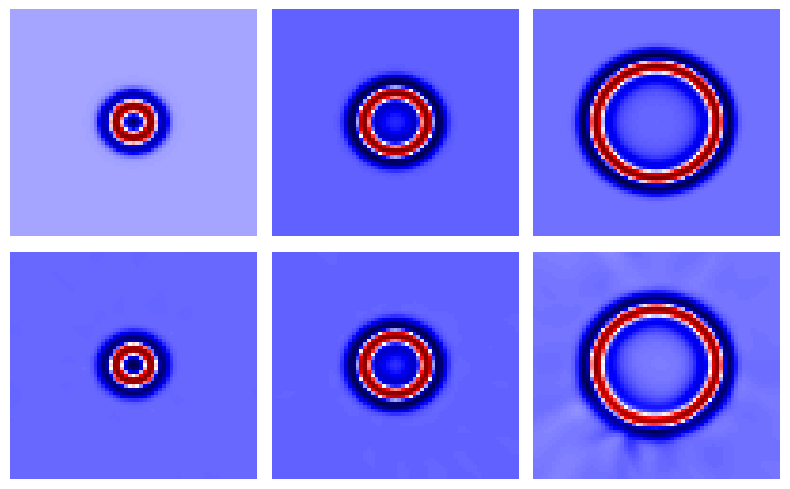

 27%|██▋       | 54993/200000 [10:03<26:02, 92.82it/s]

Epoch 55000 | Loss 0.000551 | Loss_ini 0.000297 | Loss_pde 2.535092


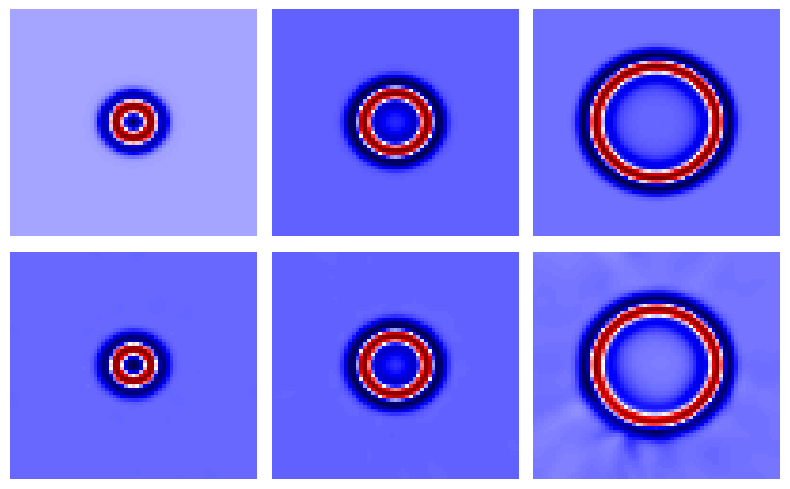

 28%|██▊       | 55994/200000 [10:14<25:51, 92.84it/s]

Epoch 56000 | Loss 0.000547 | Loss_ini 0.000298 | Loss_pde 2.482885


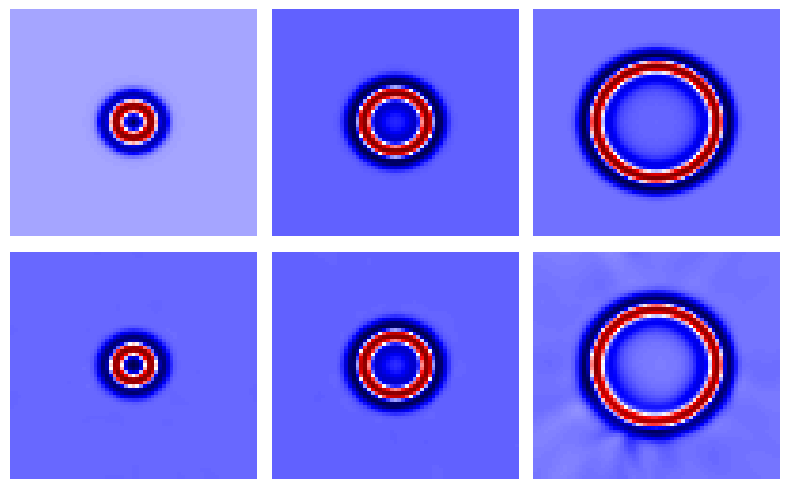

 28%|██▊       | 56995/200000 [10:25<25:40, 92.84it/s]

Epoch 57000 | Loss 0.000542 | Loss_ini 0.000298 | Loss_pde 2.439172


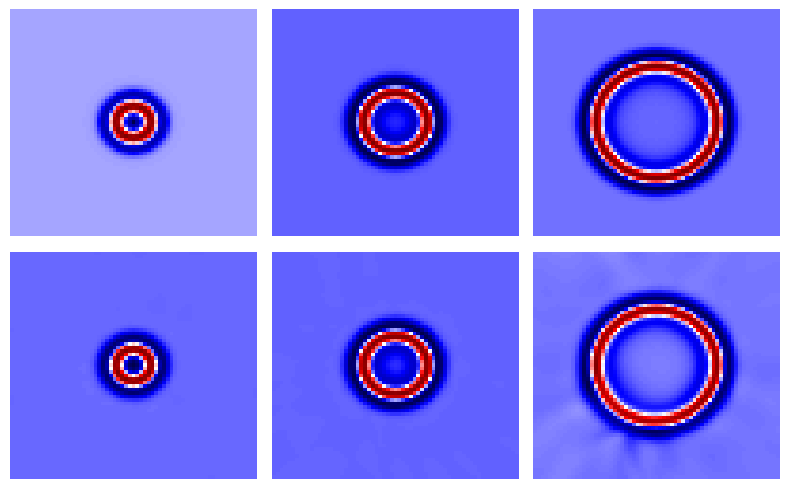

 29%|██▉       | 57995/200000 [10:36<25:26, 93.02it/s]

Epoch 58000 | Loss 0.000524 | Loss_ini 0.000285 | Loss_pde 2.387849


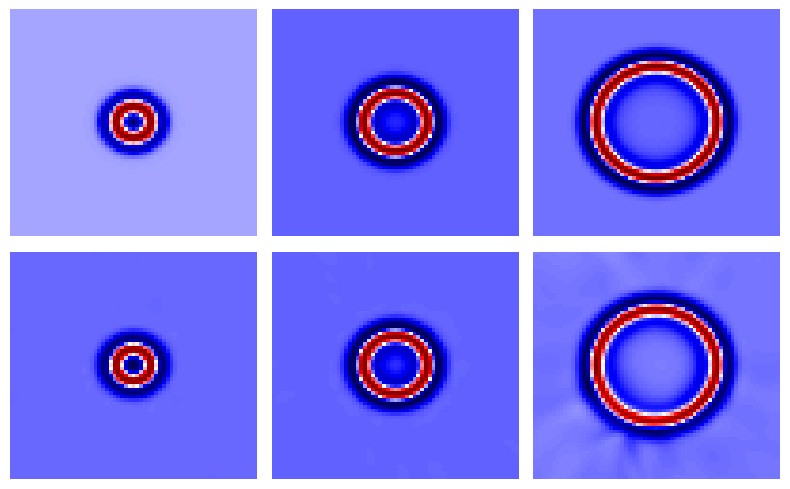

 29%|██▉       | 58996/200000 [10:47<25:20, 92.75it/s]

Epoch 59000 | Loss 0.000516 | Loss_ini 0.000281 | Loss_pde 2.343471


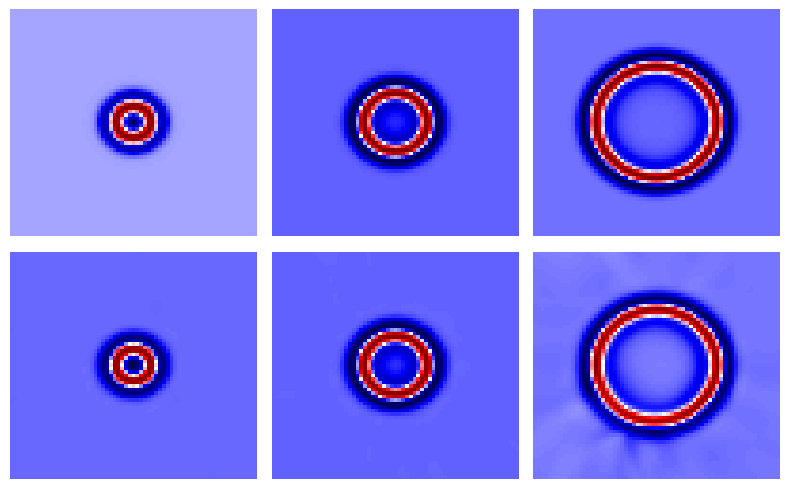

 30%|██▉       | 59996/200000 [10:58<25:09, 92.77it/s]

Epoch 60000 | Loss 0.000508 | Loss_ini 0.000278 | Loss_pde 2.299321


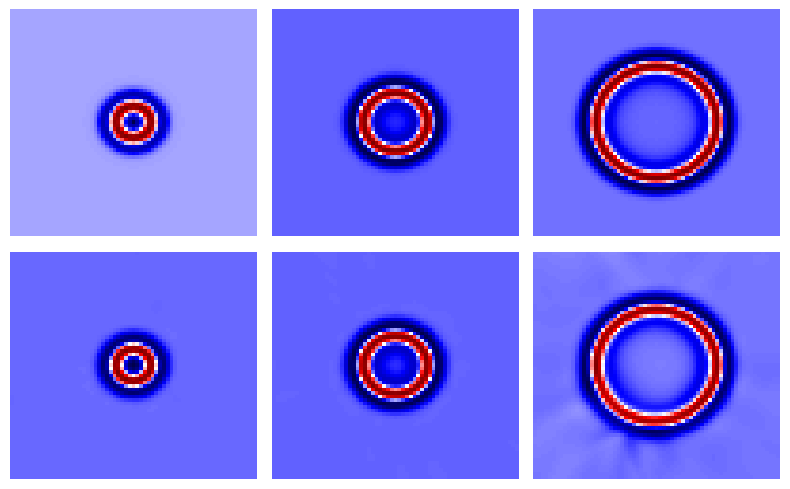

 30%|███       | 60996/200000 [11:09<24:57, 92.83it/s]

Epoch 61000 | Loss 0.000500 | Loss_ini 0.000274 | Loss_pde 2.259566


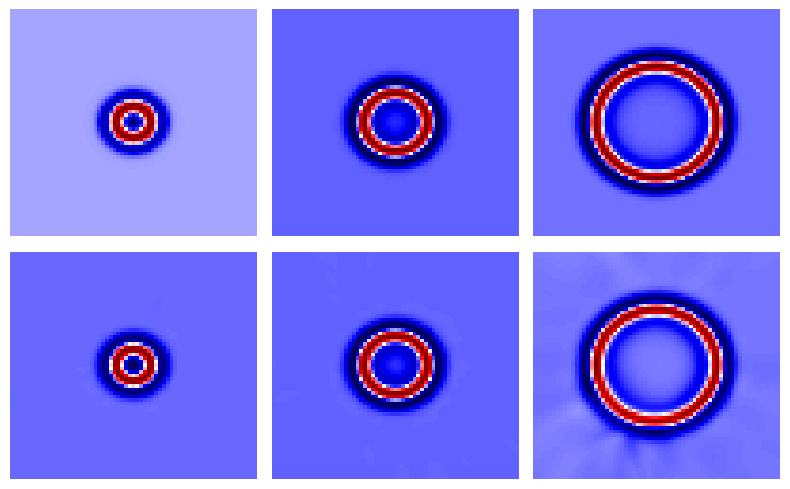

 31%|███       | 61996/200000 [11:20<24:47, 92.80it/s]

Epoch 62000 | Loss 0.000496 | Loss_ini 0.000273 | Loss_pde 2.227494


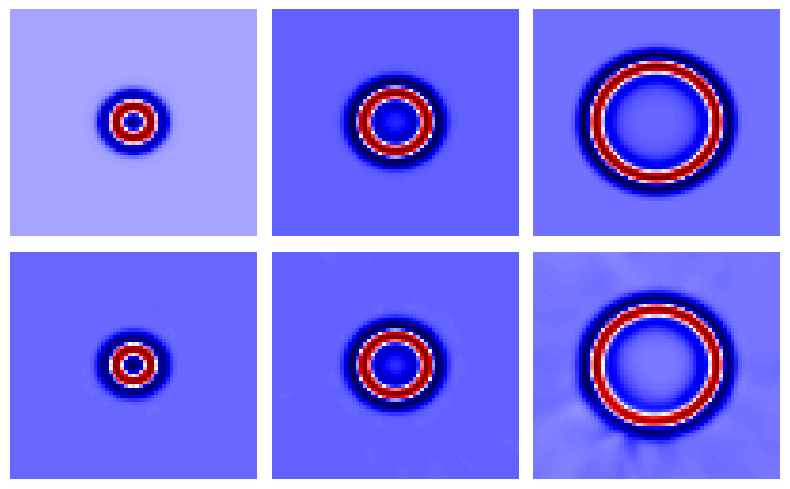

 31%|███▏      | 62996/200000 [11:31<24:37, 92.75it/s]

Epoch 63000 | Loss 0.000486 | Loss_ini 0.000268 | Loss_pde 2.180184


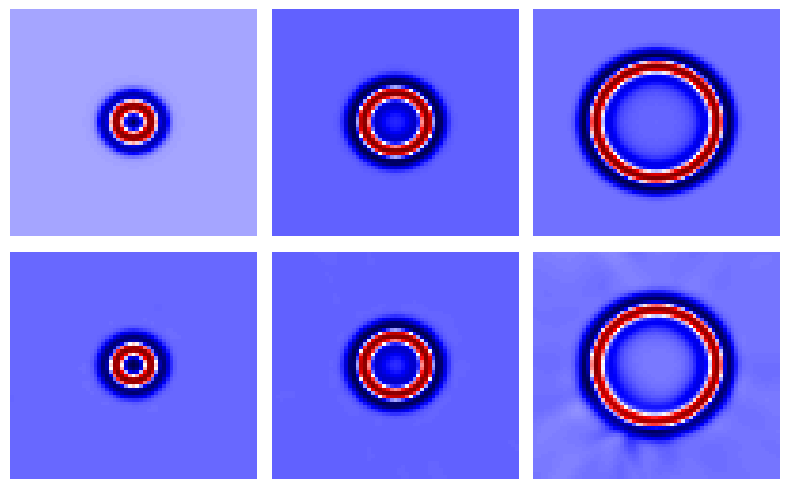

 32%|███▏      | 63996/200000 [11:42<24:25, 92.81it/s]

Epoch 64000 | Loss 0.000479 | Loss_ini 0.000265 | Loss_pde 2.144142


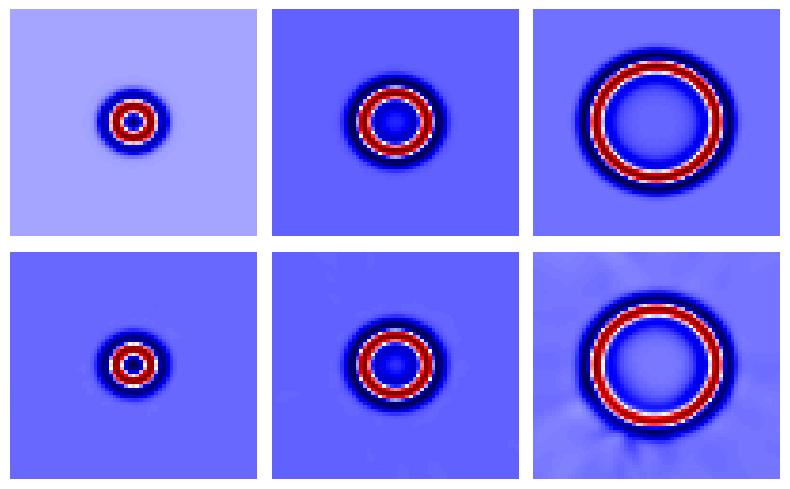

 32%|███▏      | 64996/200000 [11:53<24:16, 92.71it/s]

Epoch 65000 | Loss 0.000476 | Loss_ini 0.000264 | Loss_pde 2.118828


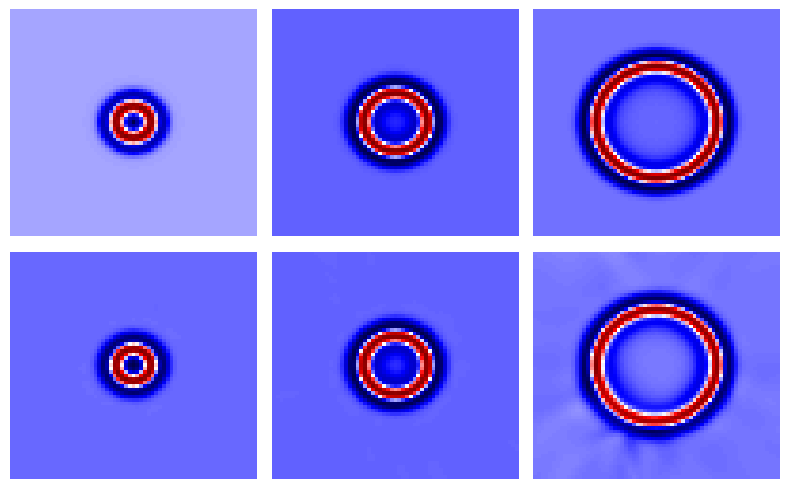

 33%|███▎      | 65996/200000 [12:04<24:03, 92.83it/s]

Epoch 66000 | Loss 0.000467 | Loss_ini 0.000259 | Loss_pde 2.073622


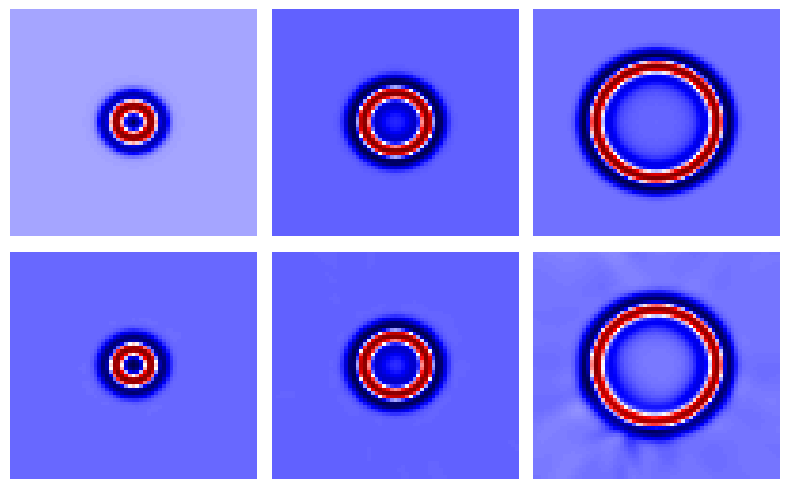

 33%|███▎      | 66996/200000 [12:15<23:53, 92.81it/s]

Epoch 67000 | Loss 0.000463 | Loss_ini 0.000258 | Loss_pde 2.041497


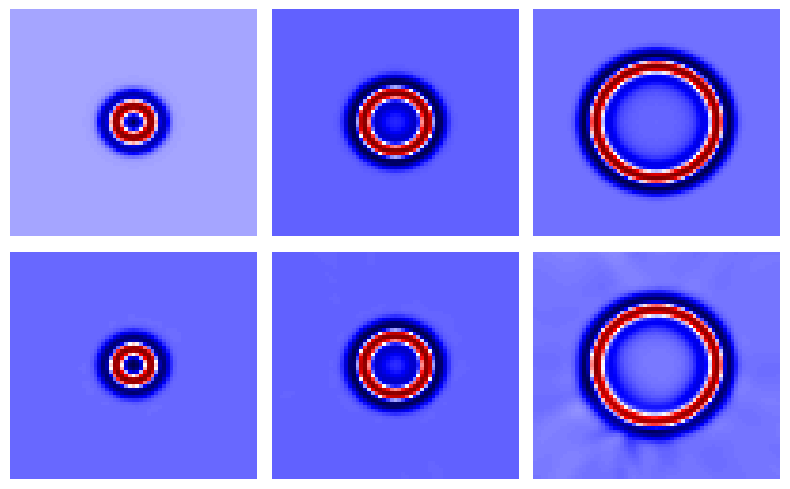

 34%|███▍      | 67996/200000 [12:26<23:42, 92.80it/s]

Epoch 68000 | Loss 0.000460 | Loss_ini 0.000259 | Loss_pde 2.016912


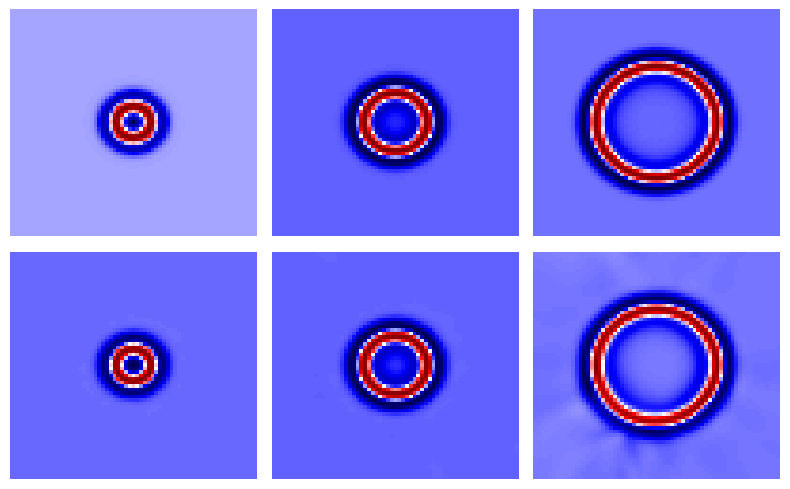

 34%|███▍      | 68997/200000 [12:37<23:32, 92.75it/s]

Epoch 69000 | Loss 0.000449 | Loss_ini 0.000251 | Loss_pde 1.976909


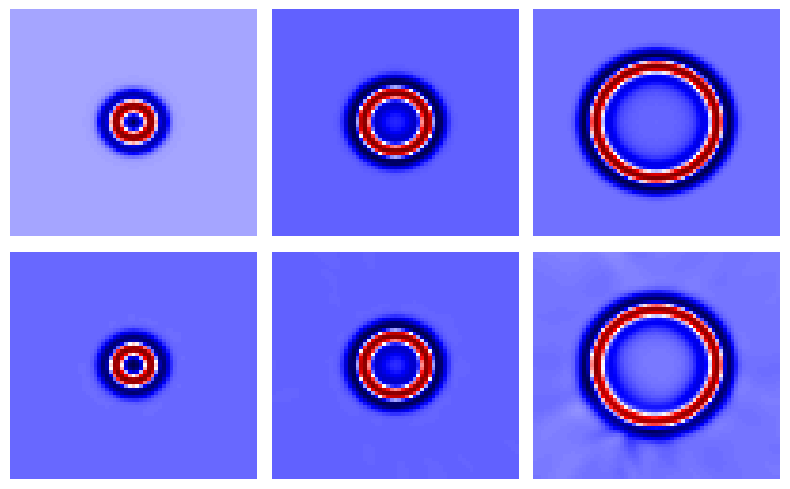

 35%|███▍      | 69997/200000 [12:48<23:21, 92.79it/s]

Epoch 70000 | Loss 0.000451 | Loss_ini 0.000256 | Loss_pde 1.947995


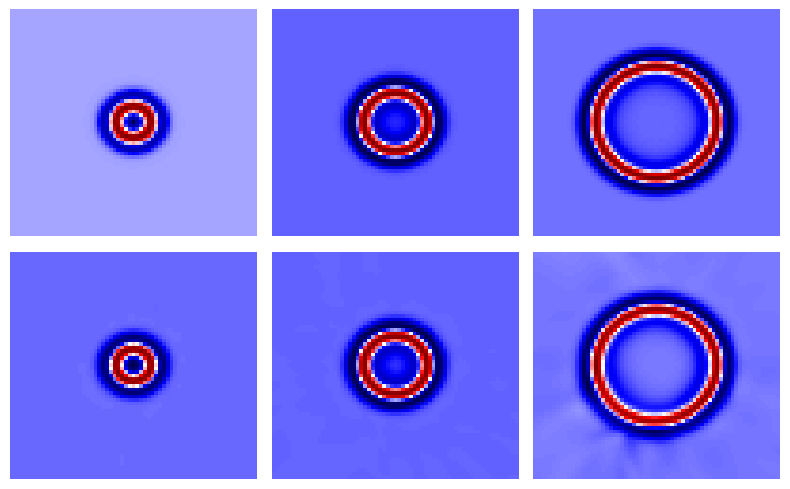

 35%|███▌      | 70997/200000 [12:59<23:09, 92.83it/s]

Epoch 71000 | Loss 0.000438 | Loss_ini 0.000246 | Loss_pde 1.921150


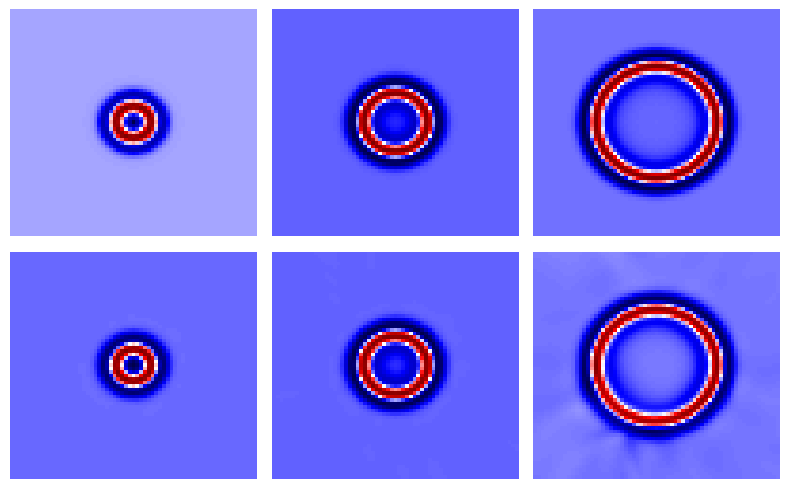

 36%|███▌      | 71997/200000 [13:10<22:59, 92.80it/s]

Epoch 72000 | Loss 0.000433 | Loss_ini 0.000244 | Loss_pde 1.891933


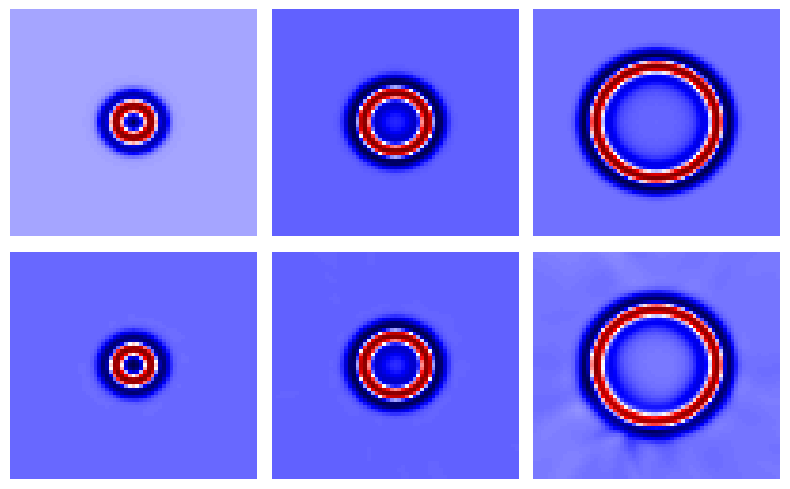

 36%|███▋      | 72997/200000 [13:21<22:47, 92.84it/s]

Epoch 73000 | Loss 0.000430 | Loss_ini 0.000244 | Loss_pde 1.862308


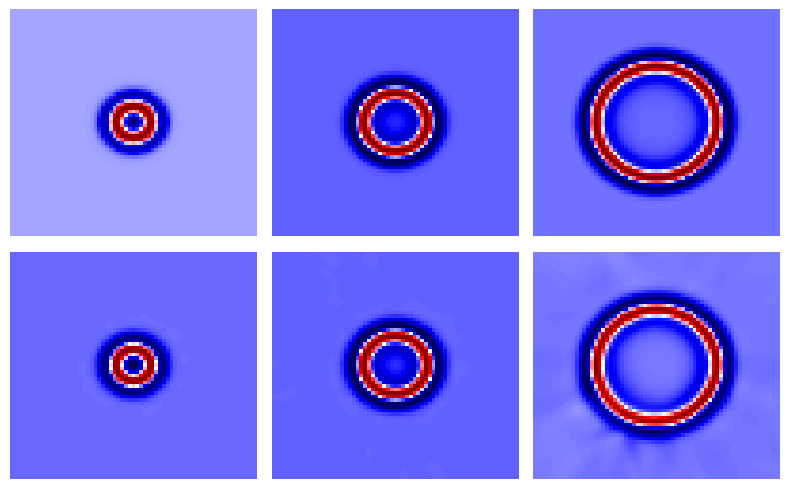

 37%|███▋      | 73997/200000 [13:32<23:01, 91.18it/s]

Epoch 74000 | Loss 0.000424 | Loss_ini 0.000240 | Loss_pde 1.840645


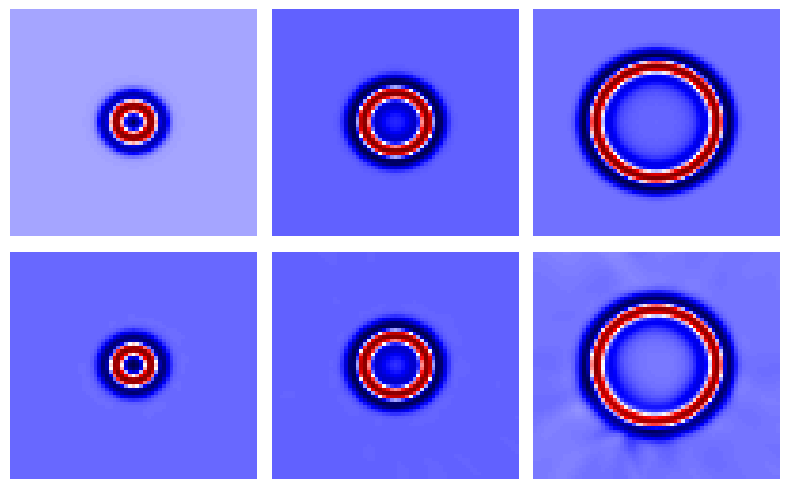

 37%|███▋      | 74996/200000 [13:43<22:27, 92.75it/s]

Epoch 75000 | Loss 0.000419 | Loss_ini 0.000237 | Loss_pde 1.812294


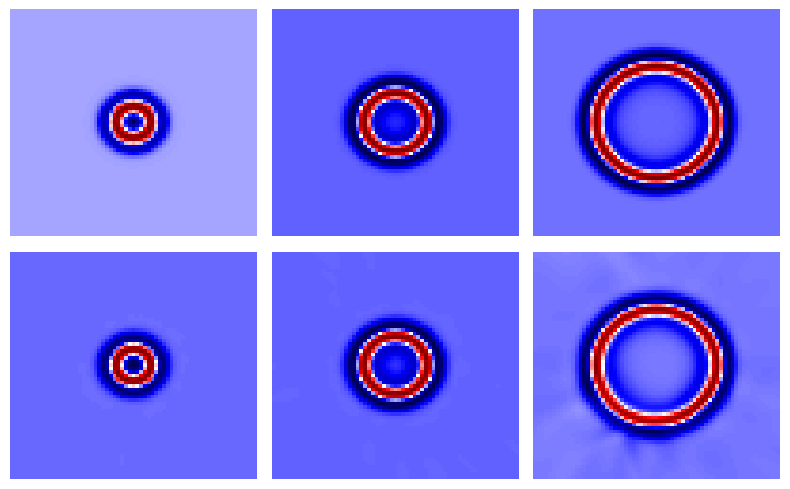

 38%|███▊      | 75997/200000 [13:54<22:15, 92.86it/s]

Epoch 76000 | Loss 0.000416 | Loss_ini 0.000237 | Loss_pde 1.785771


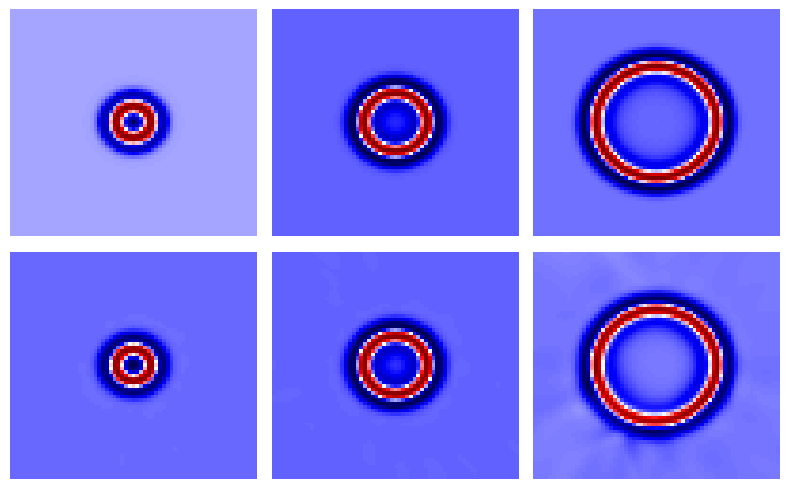

 38%|███▊      | 76997/200000 [14:05<22:06, 92.71it/s]

Epoch 77000 | Loss 0.000409 | Loss_ini 0.000233 | Loss_pde 1.762449


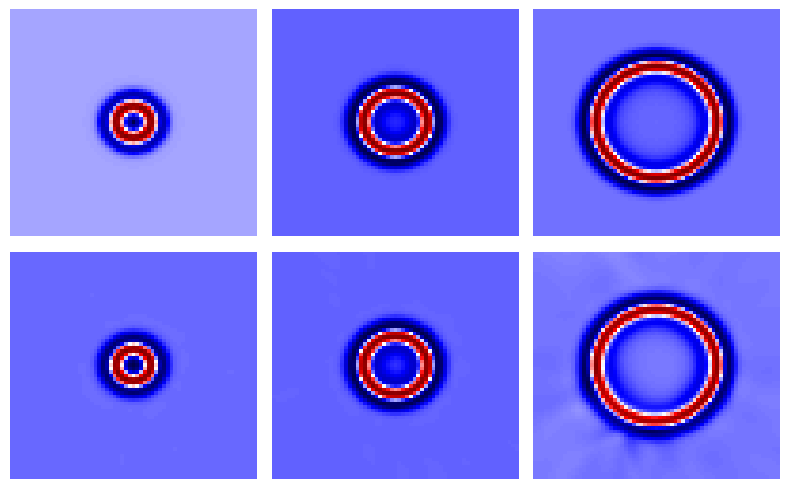

 39%|███▉      | 77997/200000 [14:16<21:53, 92.89it/s]

Epoch 78000 | Loss 0.000406 | Loss_ini 0.000232 | Loss_pde 1.738336


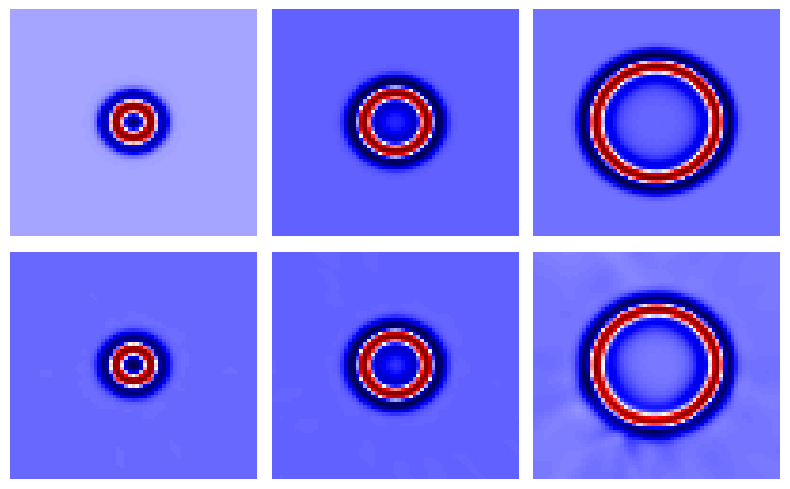

 39%|███▉      | 78998/200000 [14:27<21:40, 93.03it/s]

Epoch 79000 | Loss 0.000405 | Loss_ini 0.000233 | Loss_pde 1.717329


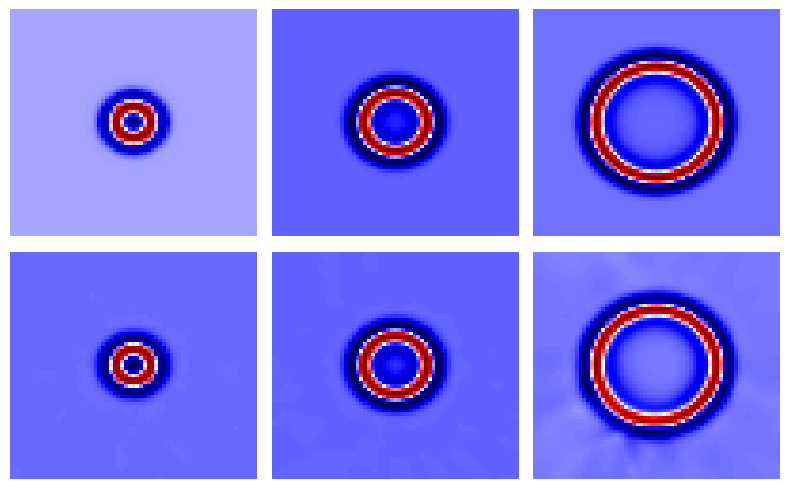

 40%|███▉      | 79998/200000 [14:38<21:32, 92.83it/s]

Epoch 80000 | Loss 0.000397 | Loss_ini 0.000227 | Loss_pde 1.694449


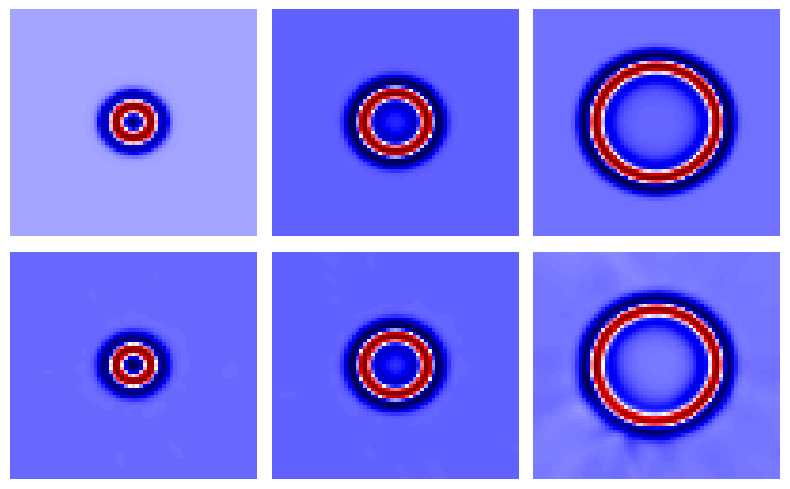

 40%|████      | 80998/200000 [14:49<21:23, 92.72it/s]

Epoch 81000 | Loss 0.000393 | Loss_ini 0.000226 | Loss_pde 1.676488


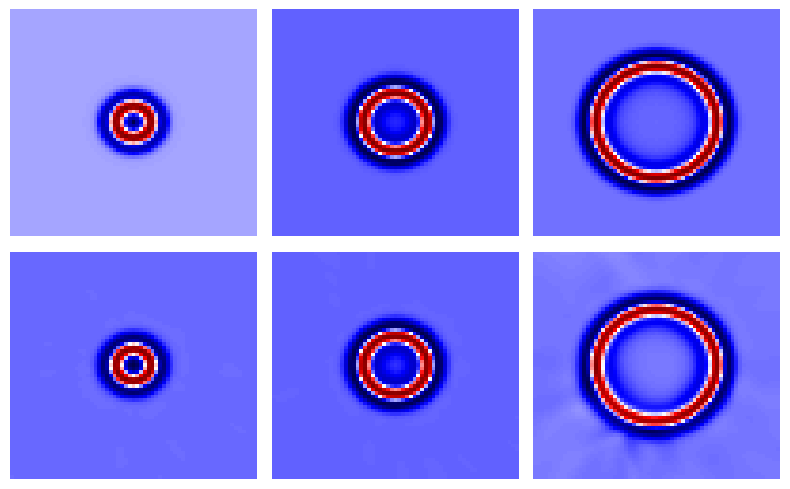

 41%|████      | 81999/200000 [15:00<21:10, 92.85it/s]

Epoch 82000 | Loss 0.000392 | Loss_ini 0.000227 | Loss_pde 1.649811


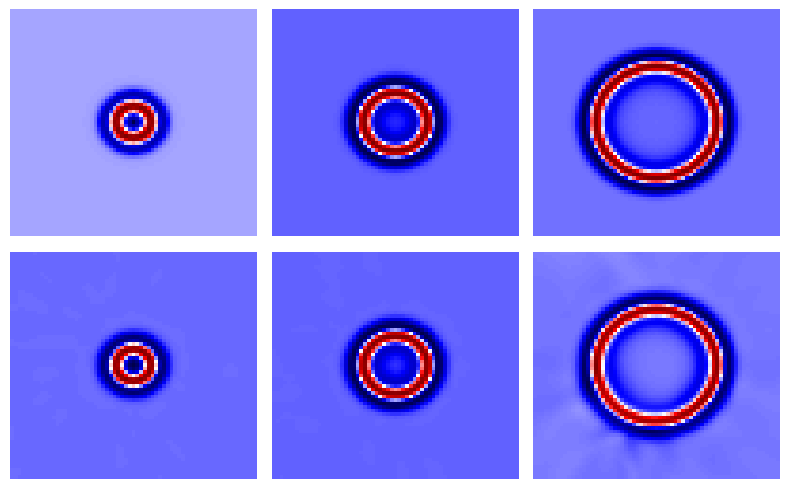

 41%|████▏     | 82999/200000 [15:11<21:01, 92.74it/s]

Epoch 83000 | Loss 0.000385 | Loss_ini 0.000222 | Loss_pde 1.631280


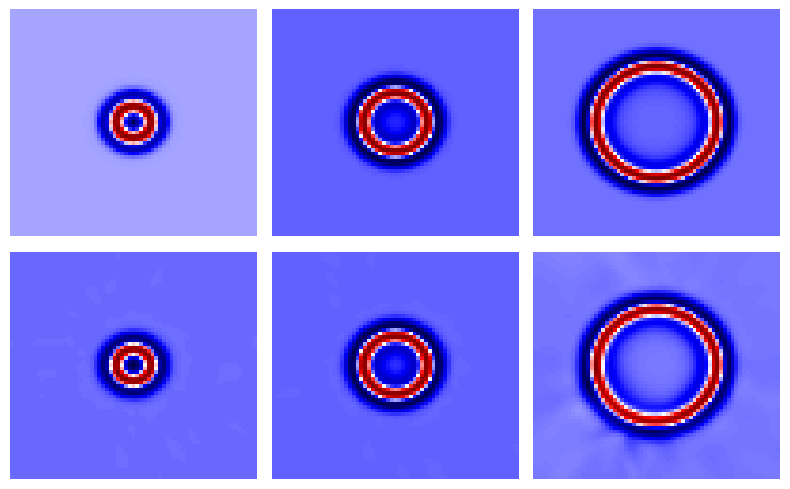

 42%|████▏     | 83999/200000 [15:22<20:48, 92.89it/s]

Epoch 84000 | Loss 0.000381 | Loss_ini 0.000220 | Loss_pde 1.610656


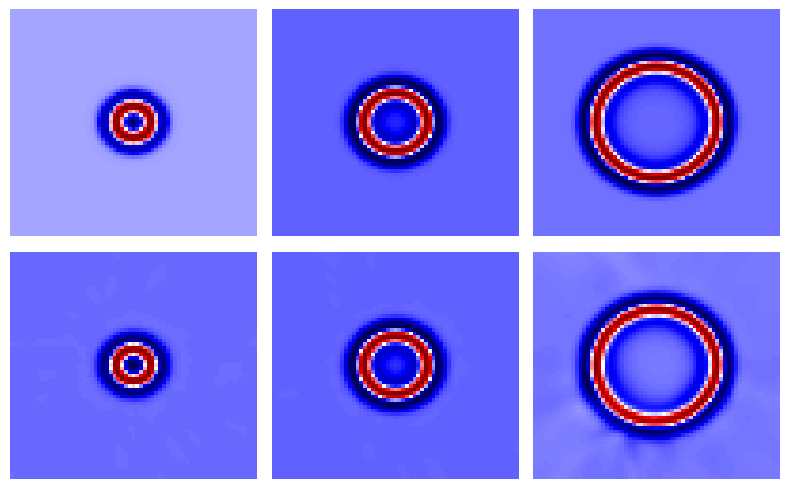

 42%|████▏     | 84755/200000 [15:31<21:06, 91.02it/s]


KeyboardInterrupt: 

In [16]:
for i in tqdm.trange(epochs):

  optimizer.zero_grad()

  # Initial condition 1
  u0_pred = pinn(xx0, zz0, tt0)
  loss_u0 = F.mse_loss(u0_pred, u0.unsqueeze(1))

  # Initial condition 2
  u1_pred = pinn(xx0, zz0, tt1)
  loss_u1 = F.mse_loss(u1_pred, u1.unsqueeze(1))

  # loss of the initial condition
  loss_ini = loss_u0 + loss_u1

  # loss of the pde
  u = pinn(x_pde, z_pde, t_pde)
  kwargs = {'create_graph': True, 'retain_graph': True}
  u_t = torch.autograd.grad(u, t_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_tt = torch.autograd.grad(u_t, t_pde, grad_outputs=torch.ones_like(u_t), **kwargs)[0]
  u_x = torch.autograd.grad(u, x_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_xx = torch.autograd.grad(u_x, x_pde, grad_outputs=torch.ones_like(u_x), **kwargs)[0]
  u_z = torch.autograd.grad(u, z_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_zz = torch.autograd.grad(u_z, z_pde, grad_outputs=torch.ones_like(u_z), **kwargs)[0]

  # loss of the pde
  u_pde = 1.5**2*(u_xx+u_zz) - u_tt
  loss_pde = F.mse_loss(u_pde, pde_zero)
  
  # total loss
  loss = loss_ini + 1e-4*loss_pde

  loss.backward()
  optimizer.step()
  if i%1000==0:
    print(f"Epoch {i} | Loss {loss.item():.6f} | Loss_ini {loss_ini.item():.6f} | Loss_pde {loss_pde.item():.6f}")
    with torch.no_grad():
      utest_pred = pinn(xx0, zz0, tt_test)
    utest_pred = utest_pred.detach().cpu().numpy().reshape(shape_after)
    fig, ax = plt.subplots(2,3, figsize=(8,5))
    show_d = [u0, u1, u_test, u0_pred, u1_pred, utest_pred]
    extent = [0, nx/1000, nz/1000, 0]
    for d, ax in zip(show_d, ax.ravel()):
        if isinstance(d, torch.Tensor):
            d = d.detach().cpu().numpy().reshape(shape_after)
        ax.imshow(d, extent=extent, cmap='seismic', aspect='auto')
        ax.set_xlabel('x (km)')
        ax.set_ylabel('z (km)')
        # disable the axis
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
nx, dh

(2.57, 10.0)

In [18]:
dh = 10
grid1m_x = int(nx/(dh/1000))
grid1m_z = int(nz/(dh/1000))
xx, zz = np.meshgrid(np.linspace(0,nx,grid1m_x),np.linspace(0,nz,grid1m_z))
xx0 = to_tensor(xx.reshape((-1,1)))
zz0 = to_tensor(zz.reshape((-1,1)))
shape = xx.shape

In [19]:
wf.shape

(1500, 257, 257)

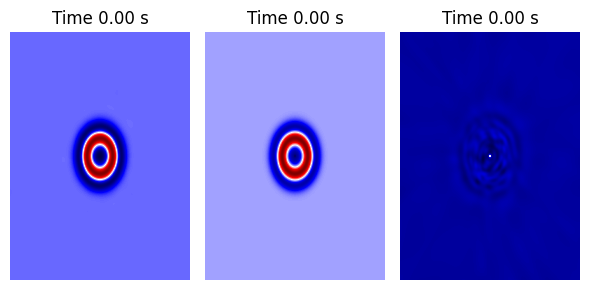

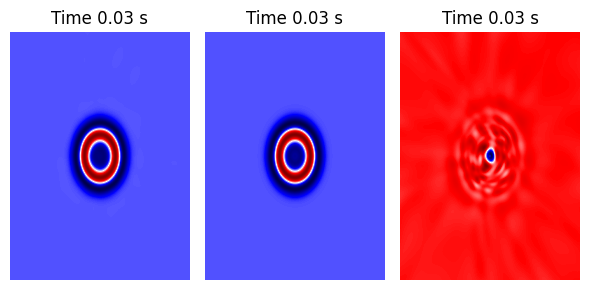

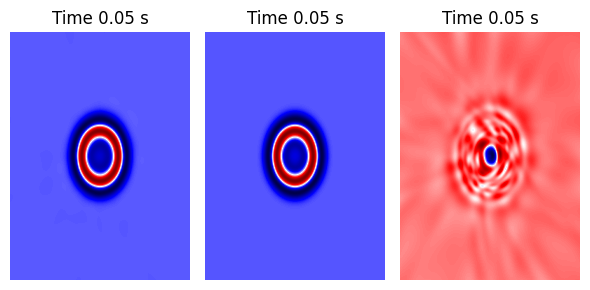

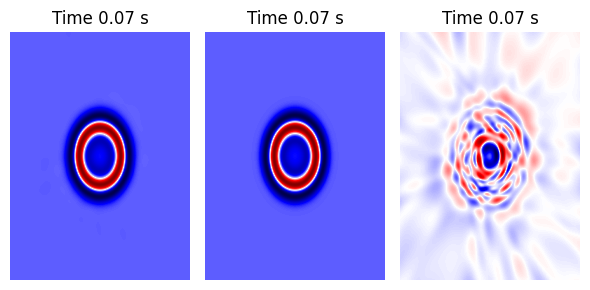

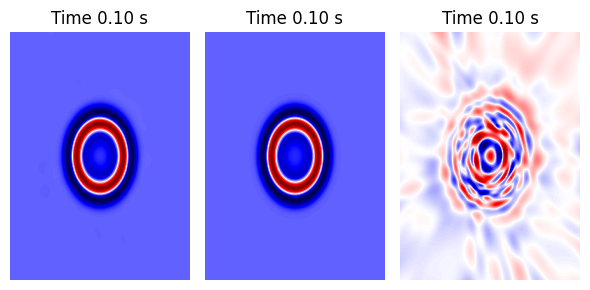

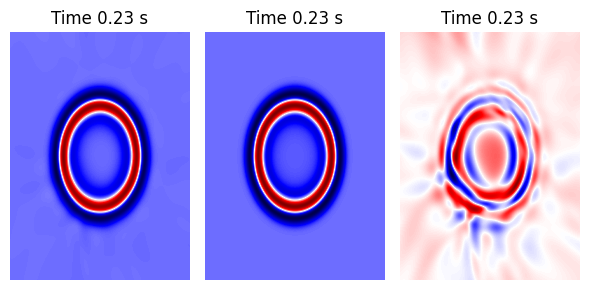

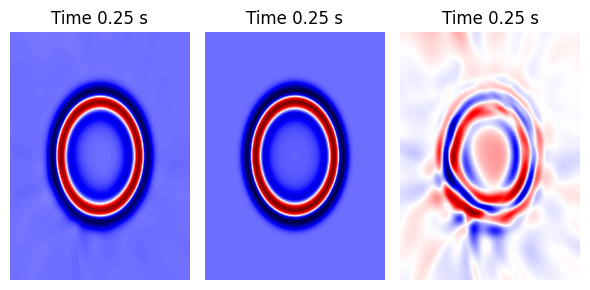

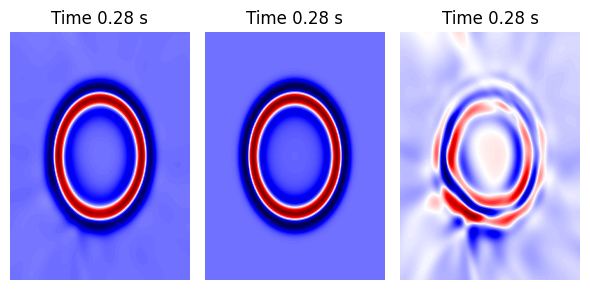

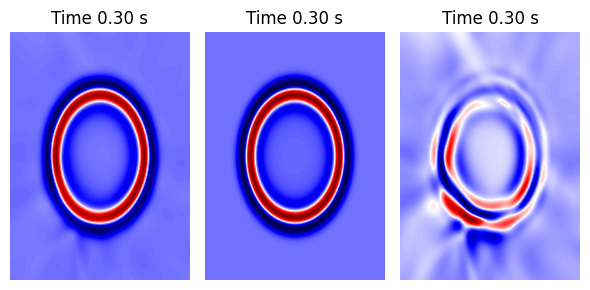

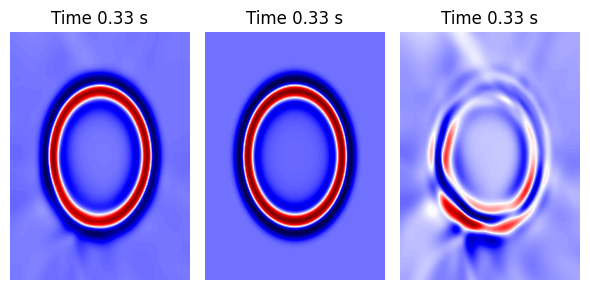

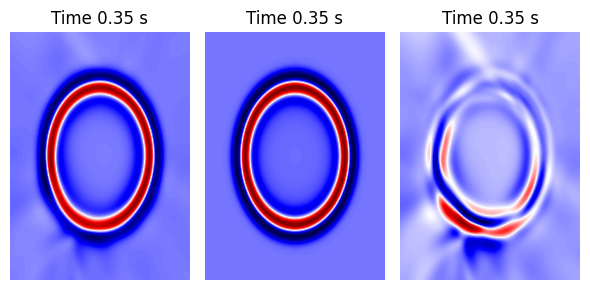

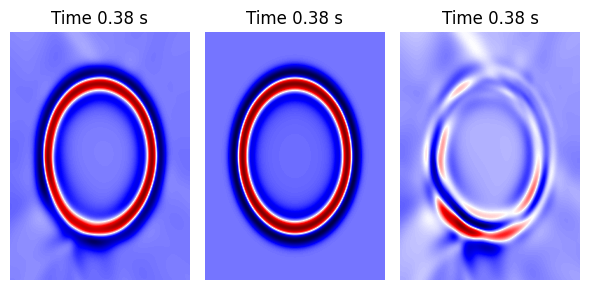

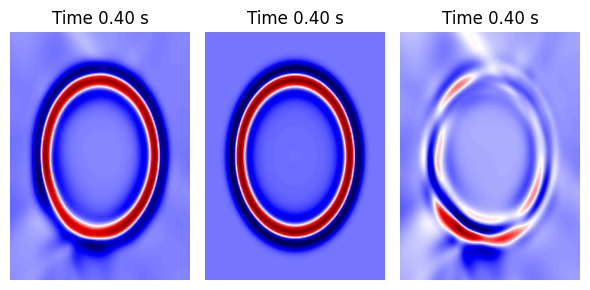

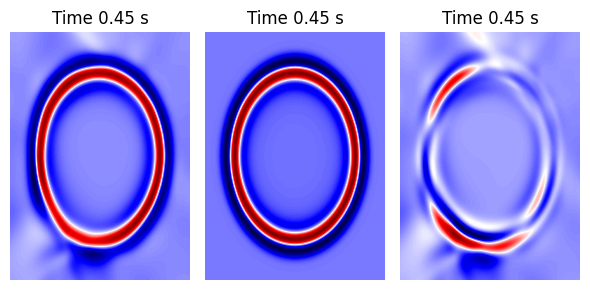

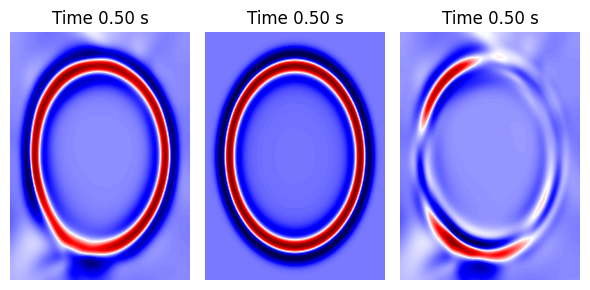

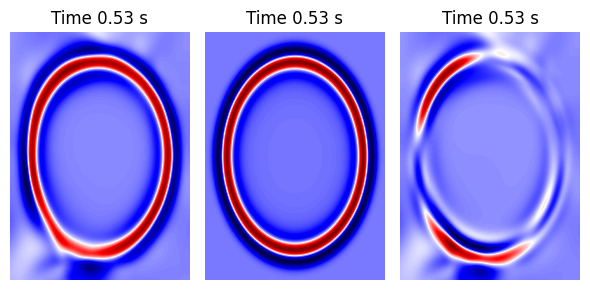

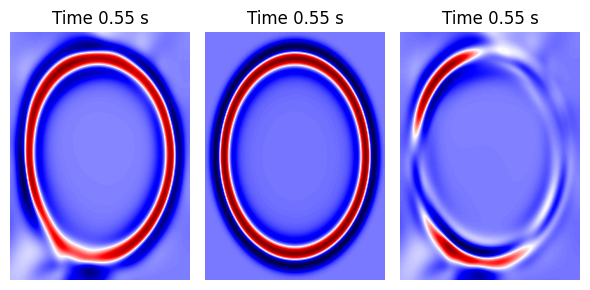

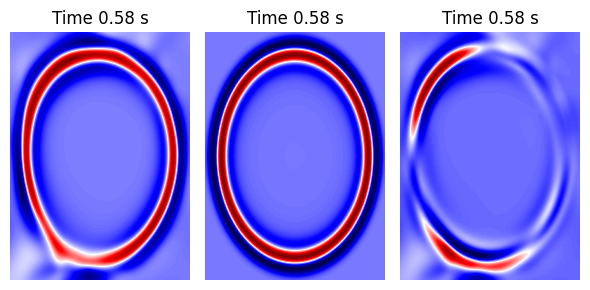

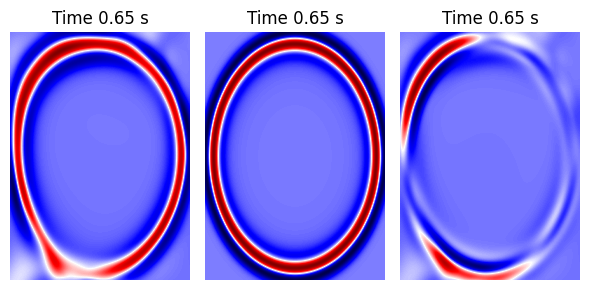

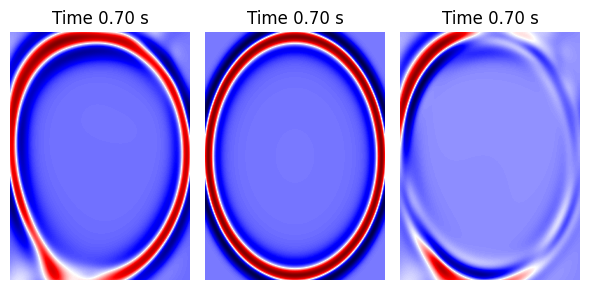

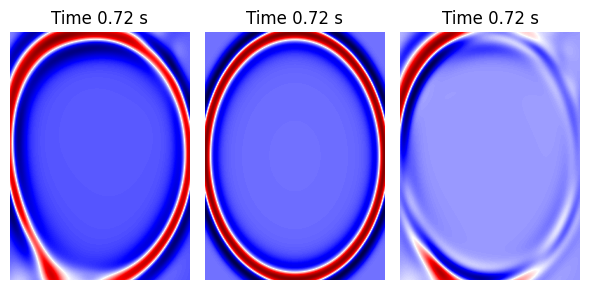

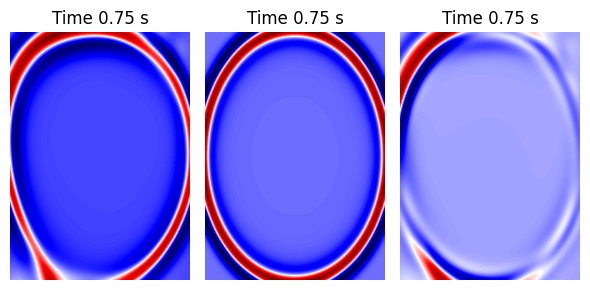

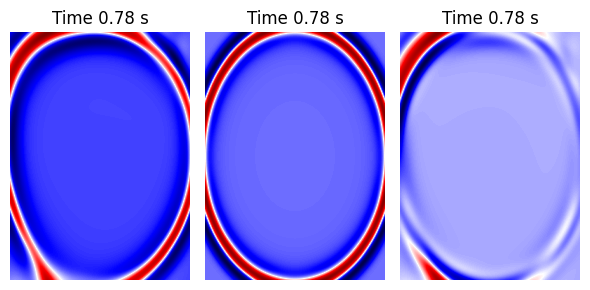

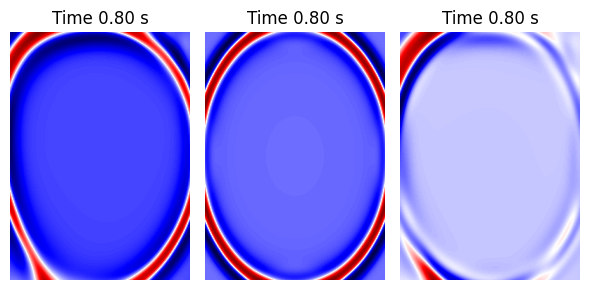

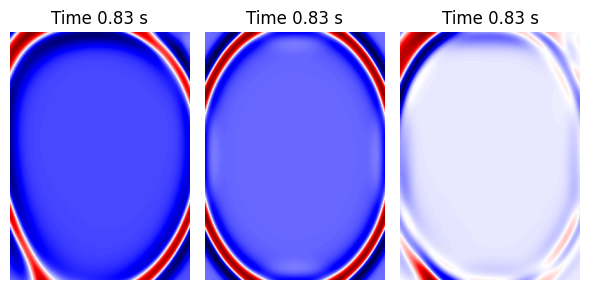

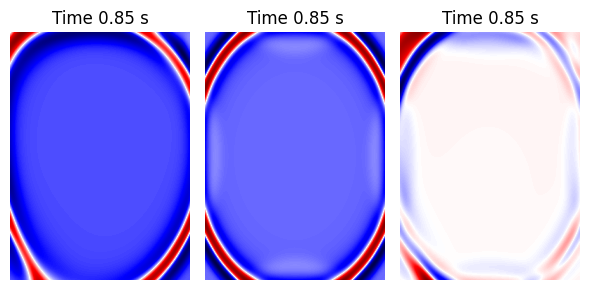

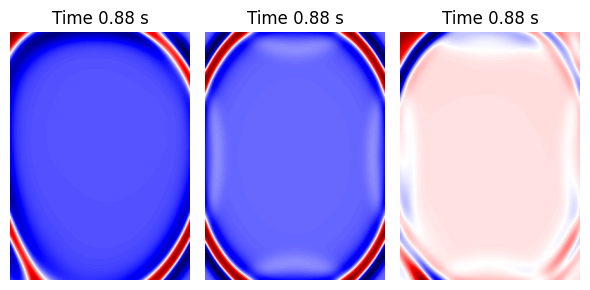

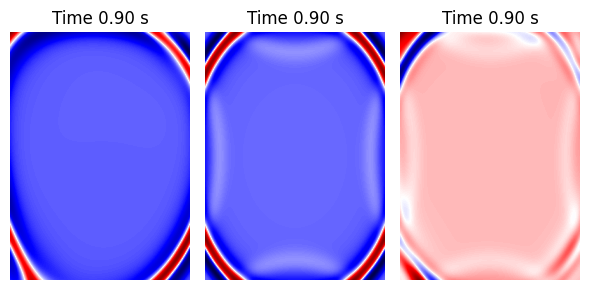

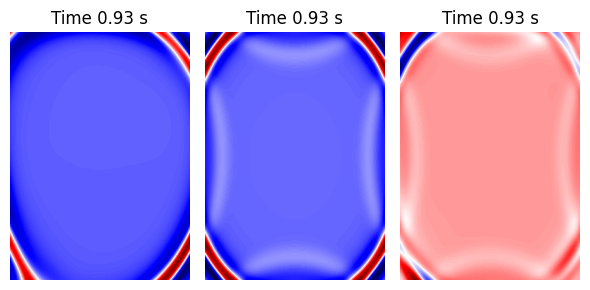

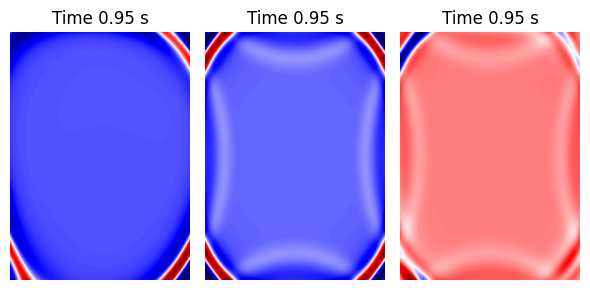

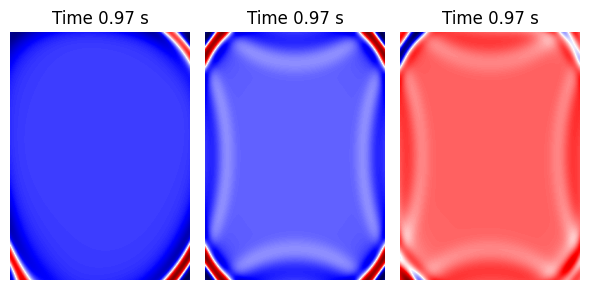

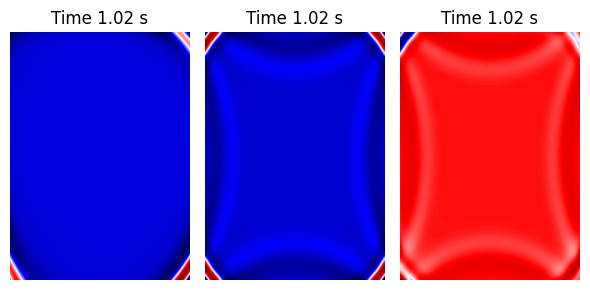

IndexError: index 1500 is out of bounds for axis 0 with size 1500

In [21]:
# predict all the time
for t in range(1200):
    if t%25==0:
        tt = t*dt*np.ones(grid1m_x*grid1m_z)
        tt = to_tensor(tt.reshape((-1,1)))
        with torch.no_grad():
            u_pred = pinn(xx0, zz0, tt).detach().cpu().numpy().reshape(shape)
        fig, axes = plt.subplots(1,3,figsize=(6,3))
        axes[0].imshow(u_pred, extent=extent, cmap='seismic', aspect='auto')
        axes[1].imshow(wf[t+400], extent=extent, cmap='seismic', aspect='auto')
        axes[2].imshow(u_pred-wf[t+400], extent=extent, cmap='seismic', aspect='auto')
        for ax in axes.ravel():
            ax.set_title(f"Time {t*dt:.2f} s")
            ax.set_xlabel('x (km)')
            ax.set_ylabel('z (km)')
            ax.axis('off')
        plt.tight_layout()
        plt.show()